In [25]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [28]:
from IPython.display import HTML
import numpy as np
import pandas as pd
import calmap
import warnings
import itertools
import wget
import os
import shutil
import datetime
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU, WeekdayLocator

from category_encoders import *

from scipy.fftpack import fft
from scipy.signal import butter, lfilter, freqz, stft

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_log_error
from math import sqrt

warnings.filterwarnings('ignore')
dataPath = '../data/'
pd.set_option('display.max_columns', None)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### 0. Functions
- Run below cell once

In [21]:
{
    "tags": [
        "hide_input",
    ]
}

# ----------------------------------#### BUILD DATASETS ####------------------------------------------------------------------------------------------------------

def Update_Data():
    urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
            'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv']

    for url in urls:
        filename = wget.download(url)
        os.remove(dataPath + filename)
        newPath = shutil.move(filename, dataPath[0:-1])
        
    conf_df = pd.read_csv(dataPath + 'time_series_covid19_confirmed_global.csv')
    deaths_df = pd.read_csv(dataPath + 'time_series_covid19_deaths_global.csv') 
    conf_df = update_initial_dfs(conf_df)
    deaths_df = update_initial_dfs(deaths_df)
    return conf_df, deaths_df

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
def update_initial_dfs(df):
    
    province_states_unique = df["Province/State"].unique()#.dropna().unique()
    dfAggregates = df[df['Province/State'].isin(province_states_unique)]
    country_region_aggregates = dfAggregates['Country/Region'].unique()

    for i, agg_country in enumerate(country_region_aggregates):
        lstRow = []
        dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
        if len(dfTemp) > 1:
            provState = agg_country #+ '_Total'          # Countries with the sum of their states
            lat = dfTemp.Lat.sum()/len(dfTemp)          # i.e. Australia with Victoria, NSW etc aggregated
            long = dfTemp.Long.sum()/len(dfTemp)
            rowEntries = [provState, agg_country, lat, long]
            lstRow = [elem for elem in rowEntries] 
            for col in dfTemp.columns[4:]:
                col_j_aggregate = dfTemp[col].sum()
                lstRow.append(col_j_aggregate)
            lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
            df = df.append(lstRow)
    
    df = df.sort_values(by = "Country/Region") 
    df['Province/State'].fillna(df['Country/Region'], inplace=True) # Countries not including their colonial states
    df = df.reset_index(drop = True)                                # i.e. United Kingdom without the "Falkland Islands"

    return df

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def create_changes_dataframe(df):
    
    province_states_unique = df["Province/State"].unique()#.dropna().unique()
    dfAggregates = df[df['Province/State'].isin(province_states_unique)]
    country_region_aggregates = dfAggregates['Country/Region'].unique()
    
    # STEP_1:
    # Some countries have individual states listed: Aggregate state-values together to gain actual country values
    for i, agg_country in enumerate(country_region_aggregates):
        lstRow = []
        dfTemp = dfAggregates[dfAggregates['Country/Region'] == agg_country]
        if len(dfTemp) > 1:
            provState = agg_country + '_Total'         # Countries with the sum of their states
            lat = dfTemp.Lat.sum()/len(dfTemp)         # i.e. Australia with Victoria, NSW etc aggregated
            long = dfTemp.Long.sum()/len(dfTemp)
            rowEntries = [provState, agg_country, lat, long]
            lstRow = [elem for elem in rowEntries] 
            for col in dfTemp.columns[4:]:
                col_j_aggregate = dfTemp[col].sum()
                lstRow.append(col_j_aggregate)
            lstRow = pd.DataFrame([lstRow], columns = dfTemp.columns)
            df = df.append(lstRow)
    
    df = df.sort_values(by = "Country/Region") 
    df['Province/State'].fillna(df['Country/Region'], inplace=True)  # Countries not including their colonial states
    df = df.reset_index(drop = True)                                 # i.e. United Kingdom without the "Falkland Islands"
    
    # STEP_2:
    # Make new columns to represent daily changes and convert US date-format to dd/mm/yy
    col_list = df.columns[0:4].tolist()
    for col in df.columns[4:]:
        if len(col) == 8: 
            col = "Diff_Prev_Day_" + col[3:5] + col[2] + col[0:2] # i.e. '12/12/20'
        elif len(col) == 7:
            col = "Diff_Prev_Day_" + col[2:4] + col[1] + col[0] # i.e.   '2/12/20'
        elif len(col) == 6:
            col = "Diff_Prev_Day_" + col[2:3] + col[1] + col[0] # i.e.   '2/2/20'
        col_list.append(col)
        
    ## STEP_3:
    # Define new dataframe to represent daily changes
    df_daily_change = pd.DataFrame(columns = col_list)
    countries_unique = df["Country/Region"].unique()
    growth_rates = []
    prevNum = 0
    len_max = len(df.columns[4:])
    
    ## STEP_4:
    # a) Iterate through each country and respective regions:
    for country in countries_unique:       
        df_country = df[df["Country/Region"] == country]
        province_states_unique = df_country["Province/State"].dropna()

        for province_state in province_states_unique:

            # b) Start dataframe recording from first registered case: (ignore all prior zero-cases on earlier dates)
            df_province_state = df_country[df_country["Province/State"] == province_state]
            df_province_state = df_province_state.loc[:, (df_province_state != 0).any(axis=0)]
            
            # d) Save first four columns (Province, Country, Lat, Long)
            #    Determine how many days prior to first case recorded (pad with 0)
            day_change_lst = df_province_state[df_province_state.columns[0:4]].values[0].tolist() 
            diff = len_max - len(df_province_state.columns[4:])
            day_change_lst += [0] * (diff) 
     
            
            # e) Calculate change from one-day to the next
            totalCases = 0
            for col in df_province_state.columns[4:]:
                new_num_cases = df_province_state[col].values[0]
                change_cases = new_num_cases - totalCases
                totalCases = new_num_cases
                day_change_lst.append(change_cases)

            df_day_i_change = pd.DataFrame([day_change_lst], columns = col_list)

            if len(df_daily_change) == 0:
                df_daily_change = df_day_i_change
            else:
                df_daily_change = pd.concat([df_daily_change, df_day_i_change])
    
    return df_daily_change

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

# ----------------------------------#### FILTERING ####------------------------------------------------------------------------------------------------------

def lowpass_butterworth(y, cutoff, order, Ts, inputVariable = None):
   
    # Detrend
    if type(y) == pd.DataFrame:
        #variable = inputVariable 
        # Detrend
        y_ = y[inputVariable].dropna() - (y[inputVariable].dropna()).sum() / len(y[inputVariable].dropna())
        # Sample-rate
        fs = 1 / Ts
        # Low-pass calculation
        b, a = return_filter_coeffs(cutoff, fs, order=order)
        y_butter = lfilter(b, a, y_) + (y[inputVariable].dropna()).sum() / len(y[inputVariable].dropna())
        
    else:
        y_ = y - sum(y)/len(y)

        # Low-pass calculation
        fs = 1 / Ts
        b, a = return_filter_coeffs(cutoff, fs, order=order)
        y_butter = lfilter(b, a, y_) + sum(y) / len(y)

    return y_butter

# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def return_filter_coeffs(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# ---------------------------------------------------------------------------------------------------------------------

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = return_filter_coeffs(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# -------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ----------------------------------#### PLOTTING ####------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------------------------------------------------------------

def getcolour():
    return np.random.rand(3,)

def plotResults(df, x, labels, dict_candidates_, log_scaling = False, stemplot = False, filterInputs_ = None):
    f = plt.figure(figsize=(15,15))
    
    for i, region in enumerate(dict_candidates_):  
        axi = f.add_subplot(str(len(dict_candidates_)) +"1" + str(i + 1))

        for j, location in enumerate(dict_candidates_[region]):
            y = df[df['Province/State'] == location].values[0][4:].tolist()
            
            if filterInputs_ is not None:
                Ts = filterInputs_[0] 
                order = filterInputs_[1] 
                cutoff = filterInputs_[2] 
                y = lowpass_butterworth(np.array(y), cutoff, order, Ts)
                #df_plot["y_filtered"] = y_filtered
                #df_plot["y_filtered"] = df_plot["y_filtered"].rolling(3).mean()

            if stemplot:
                plt.bar(x, y, alpha = 0.5, width = 0.1, label = location)
                plt.plot(x, y,  'o')
            else:
                plt.plot(x, y, alpha = 0.5, linewidth = 2, label = location)
                
        plt.xticks(rotation=45)
        plt.xlabel("date", size = 15)
        loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
        axi.xaxis.set_major_locator(loc)
        plt.ylabel(labels[0], size = 15)
        plt.title(region, size = 20)
        plt.legend(loc = "upper left")

        if log_scaling: 
            axi.set_yscale('log')
            plt.ylim([0, 10e6])

    plt.suptitle(labels[1] + " for selected countries", size = 20)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)

    
def plotBarPlots(df, list_countries, colourList, axislabels, filterInputs, plotAbsoluteCases = False):
    
    filtering = filterInputs[0]
    Ts = filterInputs[1]
    order = filterInputs[2]
    cutoff = filterInputs[3]
    
    f = plt.figure(figsize=(20,10))
    ax = f.add_subplot("111")
    
    if plotAbsoluteCases:
        for i, country in enumerate(list_countries):
            df_ = df[df['Country/Region'] == country]
            x = df_.columns[3:].tolist()
            y = df_[df_.columns[3:]].values.tolist()[0]
            plt.plot(x, y, '<-', label = country)
            plt.legend()
        plt.xticks(rotation=45)
        plt.ylabel(axislabels[0], size = 15)
        plt.xlabel("Date", size = 15)
        loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)
        return
            
    else:
        df_plot = pd.DataFrame()
        base = datetime.date(2020, 1, 22)
        numdays = len(df.columns[4:])
        date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
        province_states_unique = df["Province/State"].unique()
        inputVariable = "DayChanges"
        j = 0
        for province_state in province_states_unique:
            df_province_state = df[df["Province/State"] == province_state]
            dayChanges = df_province_state[df_province_state.columns[4:]].values[0]

            if max(dayChanges) > 0 and (province_state in list_countries):
                #j += 1
                if j%1 == 0:
                    colour = colourList[j]
                    j += 1
                    df_plot["dates"] = date_list
                    df_plot["DayChanges"] = dayChanges
                    #df_plot["growth_rates"] = df_plot["growth_rates"].rolling(3).mean()
                    if filtering:
                        y_filtered = lowpass_butterworth(df_plot, cutoff, order, Ts, inputVariable)
                        df_plot["y_filtered"] = y_filtered
                        df_plot["y_filtered"] = df_plot["y_filtered"].rolling(3).mean()
                        if j%2 == 0:
                            plt.bar(df_plot.dates,  df_plot["y_filtered"], color = colour, label = province_state, linewidth = 1, alpha = 0.2)
                        else:
                            plt.bar(df_plot.dates,  df_plot["y_filtered"], color = colour, label = province_state, linewidth = 1, alpha = 0.2)
                    else:
                         plt.bar(df_plot.dates, df_plot.DayChanges, color = colour, label = province_state, linewidth = 1, alpha = 0.2)

            #break
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    #import matplotlib.dates.WeekdayLocator
    # tick on mondays every week
    #loc = WeekdayLocator(byweekday=MO, tz=tz)

    # tick on mondays and saturdays
    loc = WeekdayLocator(byweekday=(MO,FR))
    ax.xaxis.set_major_locator(loc)
    plt.xticks(rotation=45)
    plt.ylabel(axislabels[0], size = 15)
    plt.xlabel("Date", size = 15)
    #plt.xlim(df_plot.dates[15], df_plot.dates[len(df_plot.dates) - 1])
    plt.gca().set_xlim(left=df_plot.dates[20])
    plt.title(axislabels[1], size = 20)
    #plt.ylim([-1, 100])
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

# ------------------------------------------------------------------------------------------------------------------------------------------------------

#### --------------------------------------------- PREDICTIONS + PLOTTING --------------------------------------------------------

# ------------------------------------------------------------------------------------------------------------------------------------------------------

def polyPolyRegPrediction(df, labels, countryList, degreeList, pred_window):
    f = plt.figure(figsize=(15,12))
    for i, country in enumerate(countryList):
        axi = f.add_subplot(str(len(countryList)) +"1" + str(i + 1))
        deg = degreeList[i]
        df_country = df[df['Province/State'] == country] 
        x = np.linspace(0, len(df_country[df_country.columns[4:]].values[0])-1, len(df_country[df_country.columns[4:]].values[0]))
        coeffs = np.polyfit(x, df_country[df_country.columns[4:]].values[0], deg)

        x_new = np.linspace(0, len(df_country[df_country.columns[4:]].values[0])-1 + pred_window, len(df_country[df_country.columns[4:]].values[0])+ pred_window)

        y_new = 0
        for i, coeff in enumerate(coeffs):
            power = len(coeffs) - 1 - i
            y_new += coeff * x_new ** power 

        base = datetime.date(2020, 1, 22)
        numdays = len(x_new)
        date_list_pred = [base + datetime.timedelta(days=x) for x in range(numdays)]
        plt.plot(date_list_pred, y_new, '--', linewidth = 3, label = country + ' model fit & prediction', alpha = 0.6)
        numdays = len(x)
        date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
        plt.plot(date_list, df_country[df_country.columns[4:]].values[0], label = country)
        plt.legend(loc = "upper left")
        plt.xticks(rotation=45)
        plt.xlabel("date", size = 15)
        loc = plticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals
        axi.xaxis.set_major_locator(loc)
        plt.ylabel(labels[0], size = 15)
        #plt.title(region, size = 20)
        plt.legend(loc = "upper left")


    plt.suptitle(labels[1] + " for selected countries", size = 20)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)
    
# ------------------------------------------------------------------------------------------------------------------------------------------------------
    

def plotGaussPredictions(df, labels, countryList, pred_window, alphaNoise, kernel_, filterInputs_ = None):
    f = plt.figure(figsize=(15, 12))

    for i, country in enumerate(countryList):

        df_country = df[df['Province/State'] == country] 
        x = np.linspace(0, len(df_country[df_country.columns[4:]].values[0])-1, len(df_country[df_country.columns[4:]].values[0]))

        X_train = np.atleast_2d(x).T
        y_train = np.array(df_country[df_country.columns[4:]].values[0])

        gpm = GaussianProcessRegressor(kernel=kernel_, n_restarts_optimizer=3, alpha=alphaNoise)
        if (filterInputs_ is not None) & filterInputs_[0]:
            Ts = filterInputs_[1] 
            order = filterInputs_[2] 
            cutoff = filterInputs_[3] 
            y_train = lowpass_butterworth(np.array(y_train), cutoff, order, Ts)

        gpm.fit(X_train, y_train)
        x_max = X_train.max() + pred_window
        x_min = 0
        X_ = np.linspace(x_min, x_max, int((x_max-x_min)/10)+1)
        ypm, ysm = gpm.predict(X_[:, np.newaxis], return_std=True)

        # plot prediction for msn
        ax = f.add_subplot(str(len(countryList)) +"1" + str(i + 1))

        minVal = min(min(ypm-1.960*ysm), min(y_train))
        maxVal = max(max(ypm+1.960*ysm), max(y_train))
        ax.plot(X_, ypm, lw=0.7, zorder=9, color = 'b', linestyle = '--', label = country + ' predicted curve') 
        ax.fill_between(X_, ypm-1.960*ysm, ypm+1.960*ysm, alpha=0.1, color = 'b', label = country + ' confidence interval') 
        ax.plot(X_train, y_train, 'r-', label = country + ' ground truth')
        #plt.plot([end_cycles, end_cycles], [minVal, maxVal], color = 'y', linestyle = '--', label = 'prediction start')
        plt.legend()
        
        base = datetime.date(2020, 1, 22)
        numdays = len(X_)
        date_list_pred = [base + datetime.timedelta(days=x) for x in range(numdays)]
        #plt.plot(date_list_pred, y_new, '--', linewidth = 3, label = country + ' model fit & prediction', alpha = 0.6)
        numdays = len(x)
        date_list = [base + datetime.timedelta(days=x) for x in range(numdays)]
        #plt.plot(date_list, df_country[df_country.columns[4:]].values[0], label = country)
        plt.legend(loc = "upper left")
        plt.xticks(rotation=45)
        plt.xlabel("date", size = 15)
        loc = plticker.MultipleLocator(base=10.0) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)
        plt.ylabel(labels[0], size = 15)
        #plt.title(region, size = 20)
        plt.legend(loc = "upper left")


    plt.suptitle(labels[1] + " for selected countries", size = 20)
    plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=0.92, wspace=None, hspace=None)
    
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

#### 1. Update Datasets
- Run below cell once

In [3]:
conf_df, deaths_df = Update_Data()
changes_conf_df = create_changes_dataframe(conf_df)
changes_deaths_df = create_changes_dataframe(deaths_df)

100% [..........................................................] 92572 / 92572

#### 2. EDA: Visualisation of several countries

##### Here we will analyse 4 parts of the world:
1. Selected European Countries/Neighbours
        - Part 1: Germany, Sweden, United Kingdom, Russia
        - Part 2: France, Italy, Spain, Turkey
- North & South America
        - USA, Canada, Brazil, Mexico
- Asia
        - South Korea, India, China, Afghanistan
- Australia (with states) & New Zealand
        - Victoria, New South Wales, Australia-Total, New Zealand

##### Define required variables:

In [13]:
dict_candidates = {}
dict_candidates['Europe A'] = ['Germany', 'Sweden', 'United Kingdom', 'Russia']
dict_candidates['Europe B'] = ['France', 'Italy', 'Spain', 'Turkey']
dict_candidates['Asia'] = ['Korea, South', 'India', 'China', 'Afghanistan']
dict_candidates['North & South America'] = ['US', 'Canada', 'Brazil', 'Mexico']
dict_candidates['Australia & New Zealand'] = ['Australia', 'New Zealand', 'Victoria', 'New South Wales']
x = conf_df.columns[4:].tolist()

#### ------------------------------------------------------ Visualisation: Country line plots -----------------------------------------------------------------------------------

##### 2.1 Confirmed number of cases

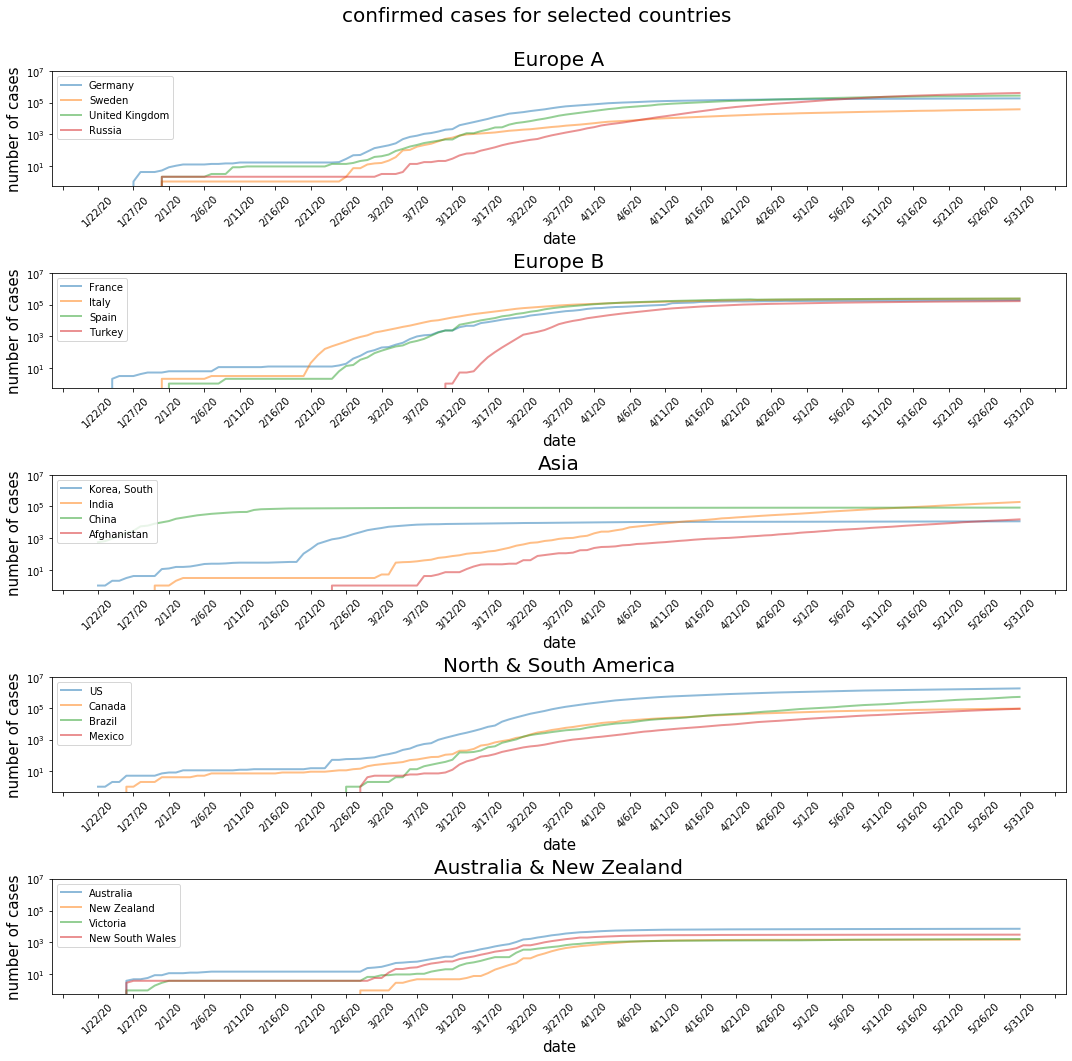

In [44]:
log_scaling = True
labels = ['number of cases', 'confirmed cases']
plotResults(conf_df, x, labels, dict_candidates, log_scaling)

##### 2.2 Confirmed number of deaths

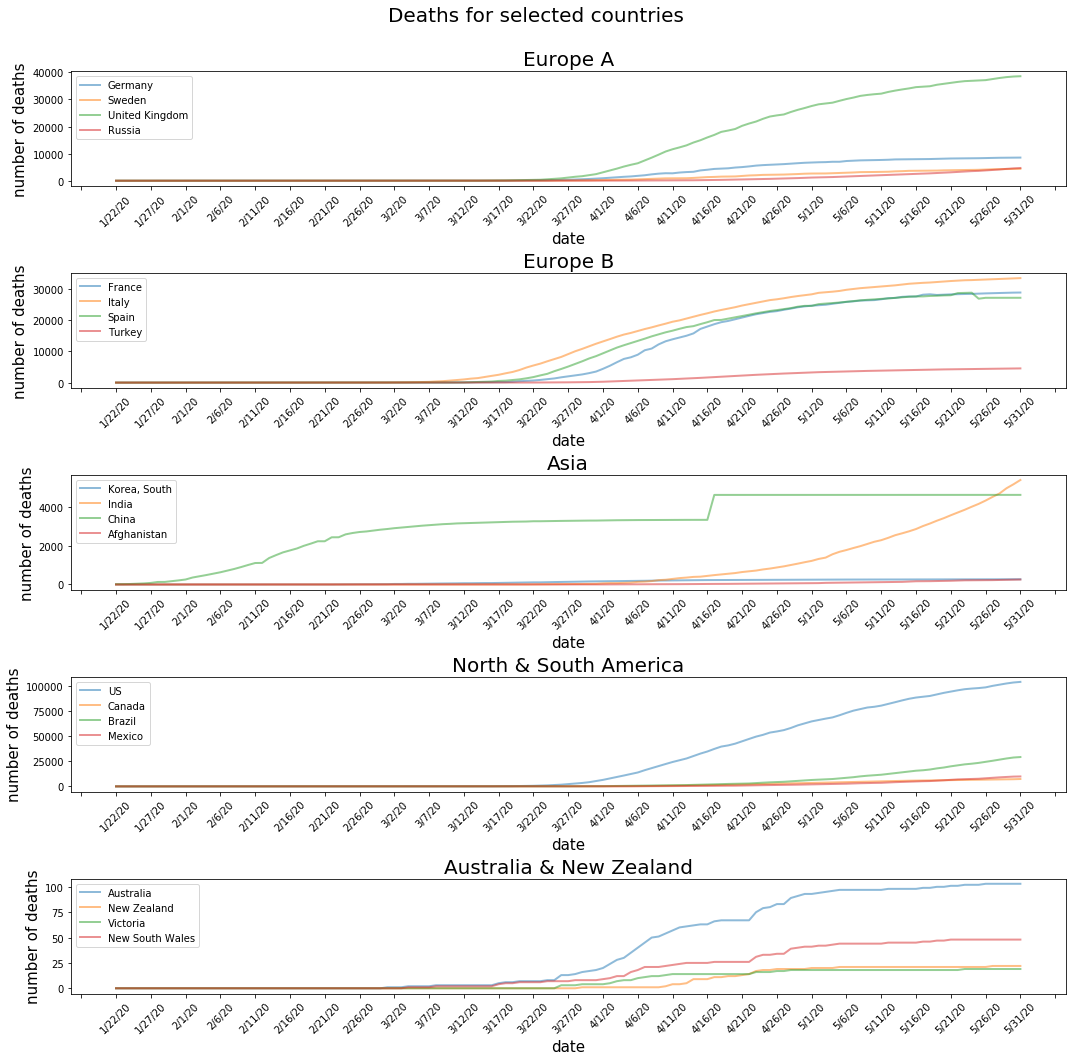

In [43]:
labels = ['number of deaths', 'Deaths']
plotResults(deaths_df, x, labels, dict_candidates)

##### 2.3 Newly confirmed cases per day

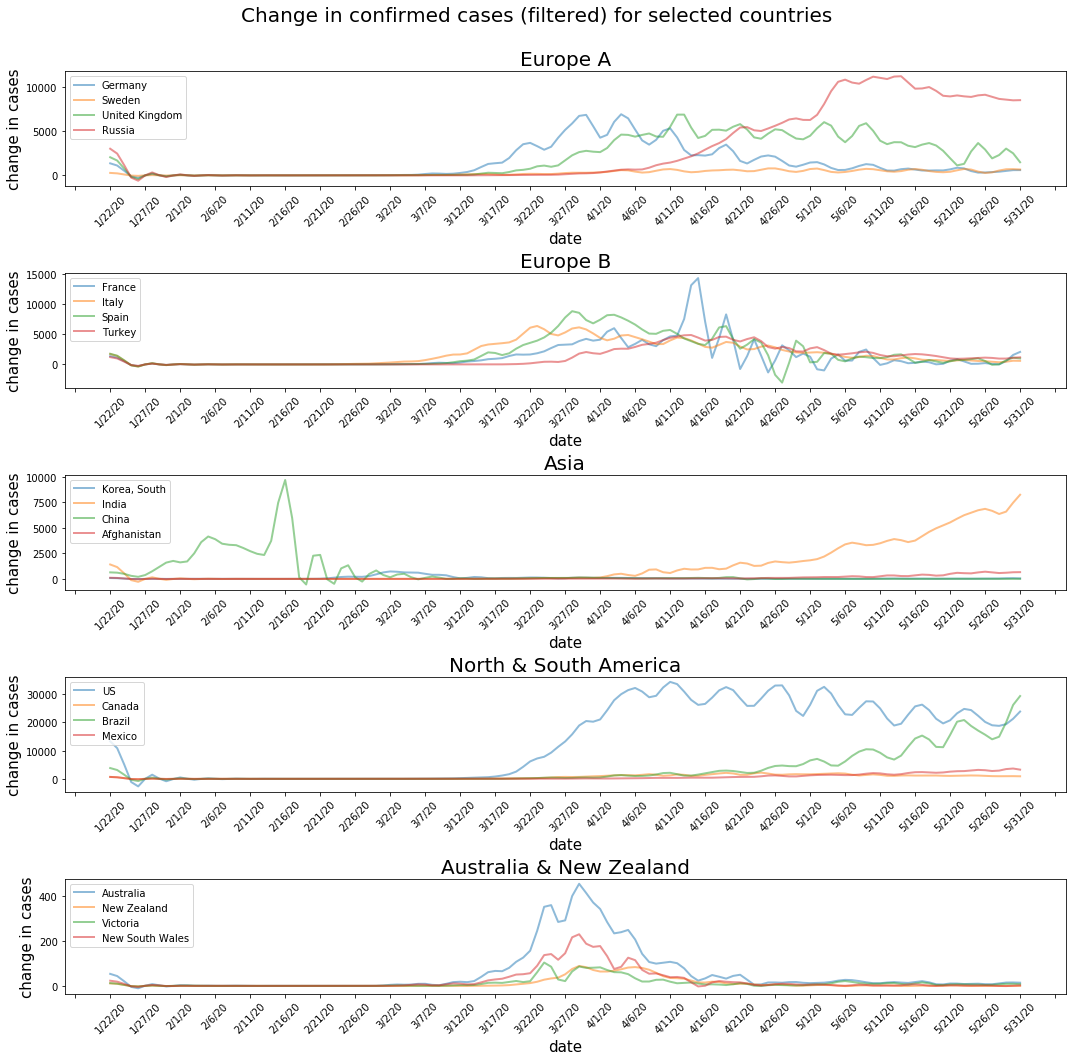

In [66]:
labels = ['change in cases', 'Change in confirmed cases (filtered)']
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [Ts, order, cutoff]
plotResults(changes_conf_df, x, labels, dict_candidates, filterInputs_ = filterInputs)

##### 2.4 Newly confirmed deaths per day

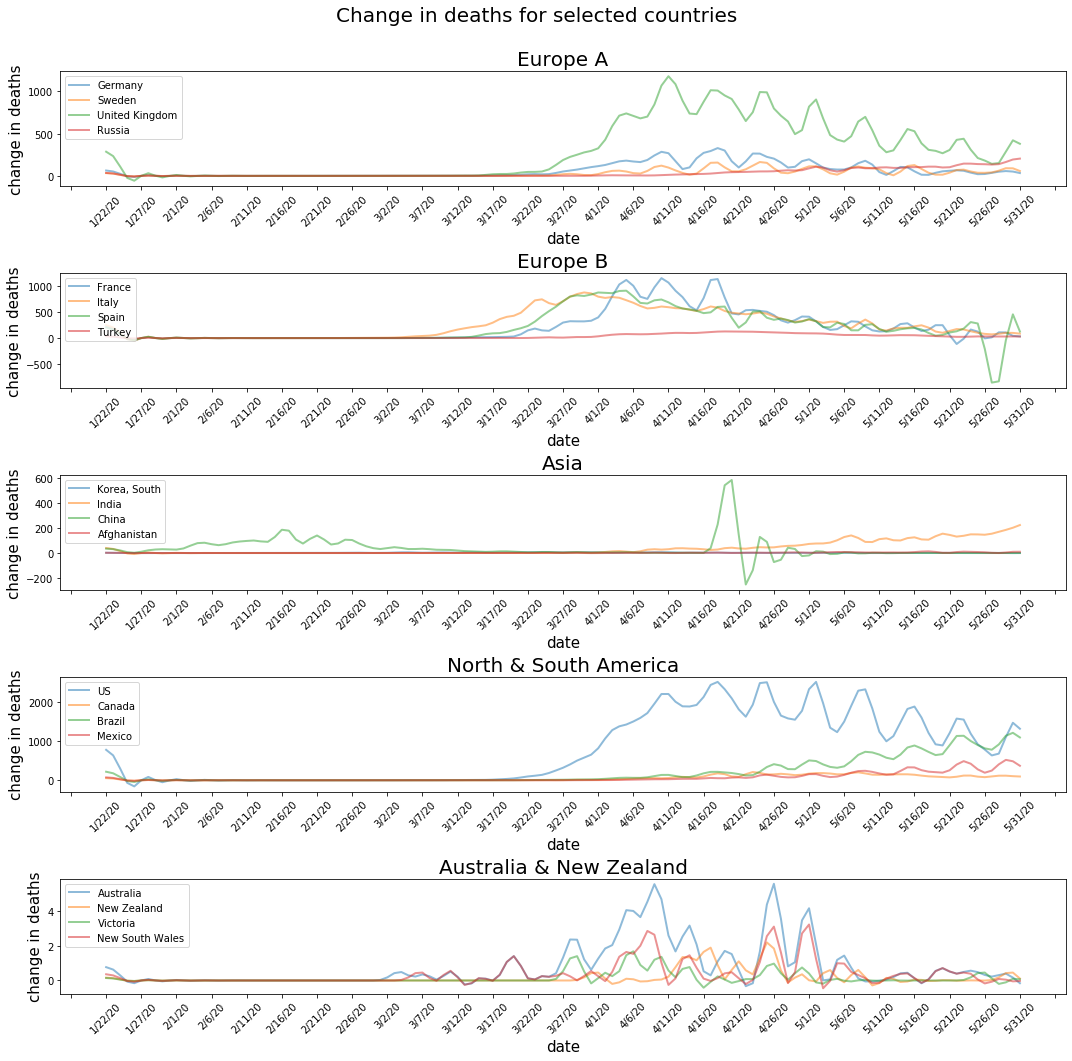

In [41]:
labels = ['change in deaths', 'Change in deaths']
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [Ts, order, cutoff]
plotResults(changes_deaths_df, x, labels, dict_candidates, filterInputs_ = filterInputs)

#### ------------------------------------------------------ Visualisation: Country Bar plots -----------------------------------------------------------------------------------

##### 2.5 Total Cases - Single bar plots

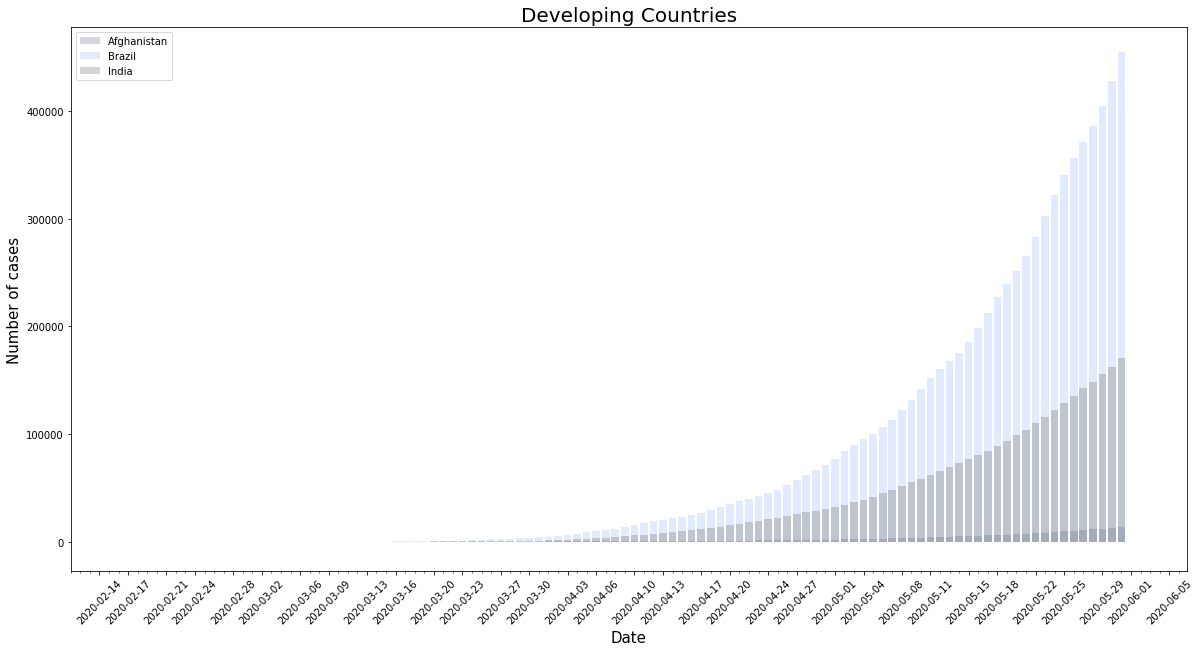

In [65]:
aus = 0
devCountries = 1
if aus:
    list_countries = ['Australia', 'Victoria', 'New South Wales'] #'US_'
    labels = ["Number of cases", "Australian states"]
    
elif devCountries:
    list_countries = ['Brazil', 'India', 'Afghanistan']
    labels = ["Number of cases", "Developing Countries"]
    
else:
    list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']
    labels = ["Number of cases", "Western Europe"]
    
    

colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())

filtering = True
Ts = 1 
order = 6  
cutoff = 0.3
filterInputs = [filtering, Ts, order, cutoff]
plotBarPlots(conf_df, list_countries, colourList, labels, filterInputs)

#### 2.6. New cases per day - Single bar plots

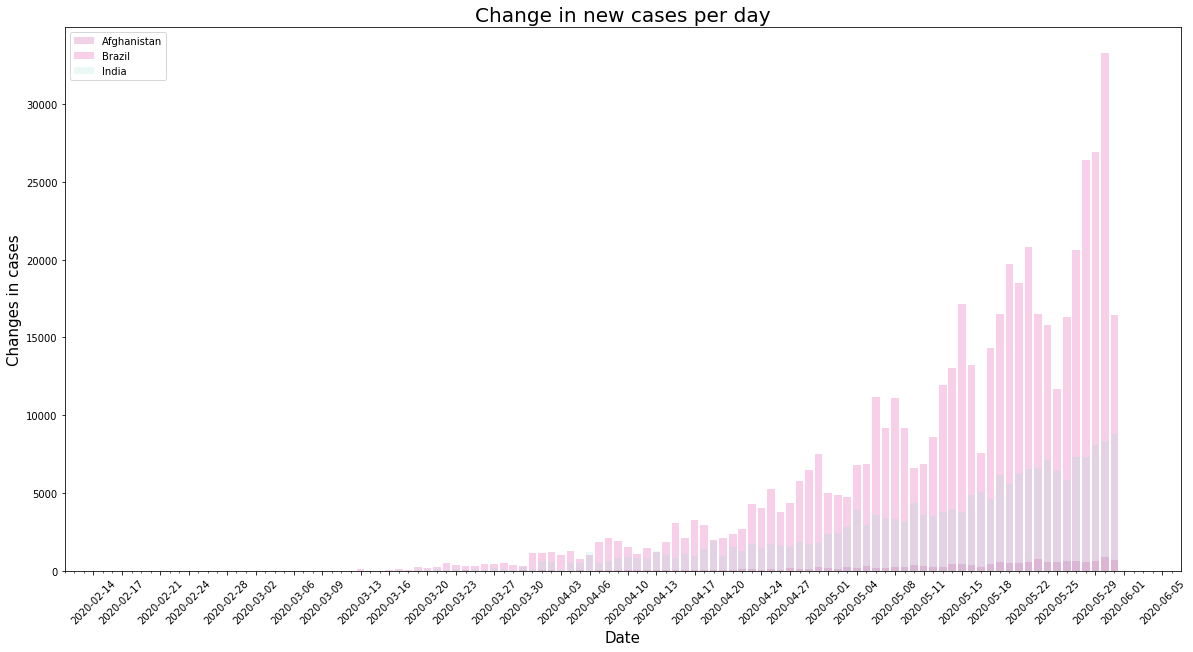

In [47]:
aus = 0
devCountries = 1
if aus:
    list_countries = ['Australia', 'Victoria', 'New South Wales'] #'US_'
    labels = ["Number of cases", "Australian states"]
    
elif devCountries:
    list_countries = ['Brazil', 'India', 'Afghanistan']
    labels = ["Number of cases", "Developing Countries"]
    
else:
    list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']
    labels = ["Number of cases", "Western Europe"]

colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
axislabels = ["Changes in cases", "Change in new cases per day"]
filtering = False
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotBarPlots(changes_conf_df, list_countries, colourList, axislabels, filterInputs)

##### 2.5 Total deaths - Single bar plots

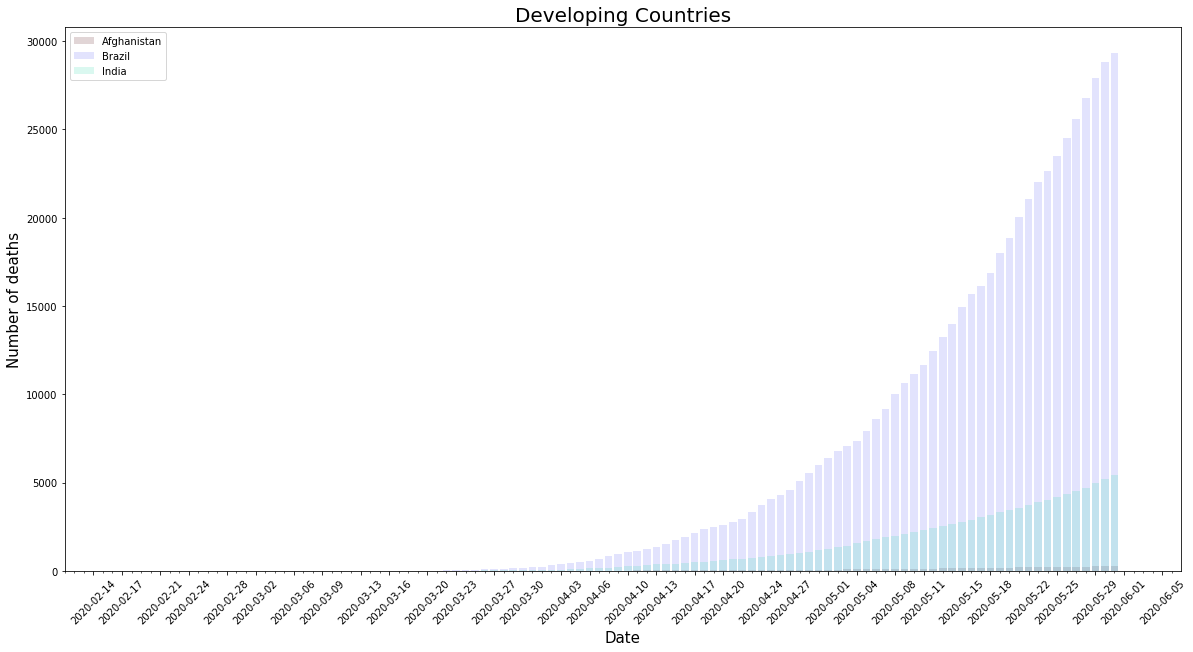

In [46]:
aus = 0
devCountries = 1
if aus:
    list_countries = ['Australia', 'Victoria', 'New South Wales'] #'US_'
    labels = ["Number of cases", "Australian states"]
    
elif devCountries:
    list_countries = ['Brazil', 'India', 'Afghanistan']
    labels = ["Number of deaths", "Developing Countries"]
    
else:
    list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']
    labels = ["Number of cases", "Western Europe"]
    
    

colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())

filtering = False
Ts = 1 
order = 6  
cutoff = 0.3
filterInputs = [filtering, Ts, order, cutoff]
plotBarPlots(deaths_df, list_countries, colourList, labels, filterInputs)

#### 2.6. New deaths per day - Single bar plots

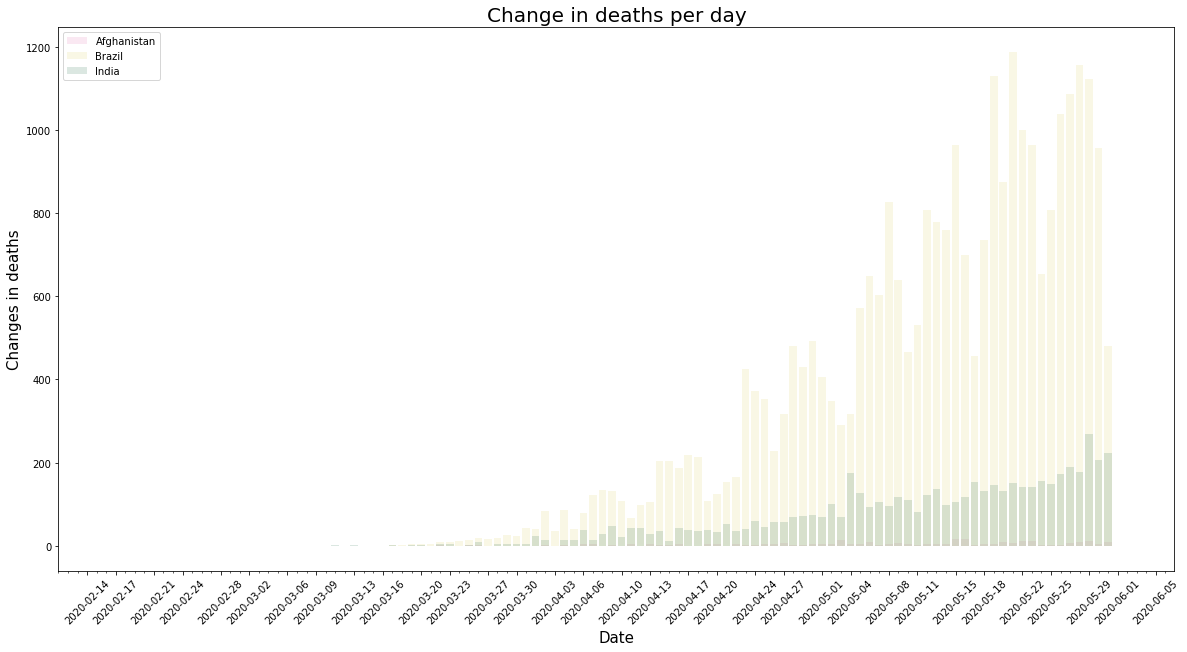

In [48]:
aus = 0
devCountries = 1
if aus:
    list_countries = ['Australia', 'Victoria', 'New South Wales'] #'US_'
    labels = ["Number of cases", "Australian states"]
    
elif devCountries:
    list_countries = ['Brazil', 'India', 'Afghanistan']
    labels = ["Number of cases", "Developing Countries"]
    
else:
    list_countries = ['France', 'Germany', 'Italy', 'United Kingdom', 'Spain', 'Netherlands', 'Sweden']
    labels = ["Number of cases", "Western Europe"]

colourList = []
for i in range(0, len(list_countries)+1):
    colourList.append(getcolour())
axislabels = ["Changes in deaths", "Change in deaths per day"]
filtering = False
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotBarPlots(changes_deaths_df, list_countries, colourList, axislabels, filterInputs)

#### 3. Basic quick predictions ------------------------------------------------------------------------------------------------------------------------------------------------

#### 3.1 Polynomial regression - 'n' degrees

- Selected countries 

#### 3.1.1 Total number of cases

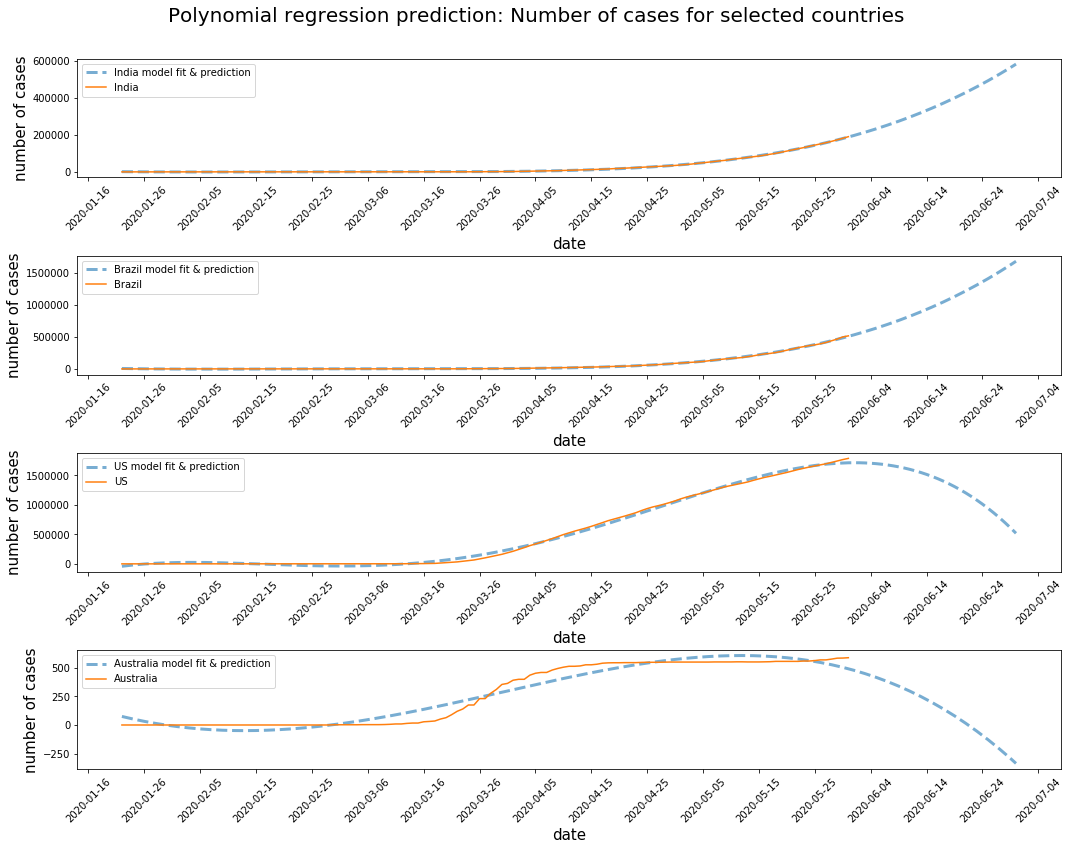

In [109]:
labels = ['number of cases', 'Polynomial regression prediction: Number of cases']
countryList = ['India', 'Brazil', 'US', 'Australia']
degreeList = [4, 4, 4, 4]
prediction_window = 30 #(30 days ~ 1 month)
polyPolyRegPrediction(conf_df, labels, countryList, degreeList, prediction_window)

#### 3.1.2 Total number of deaths

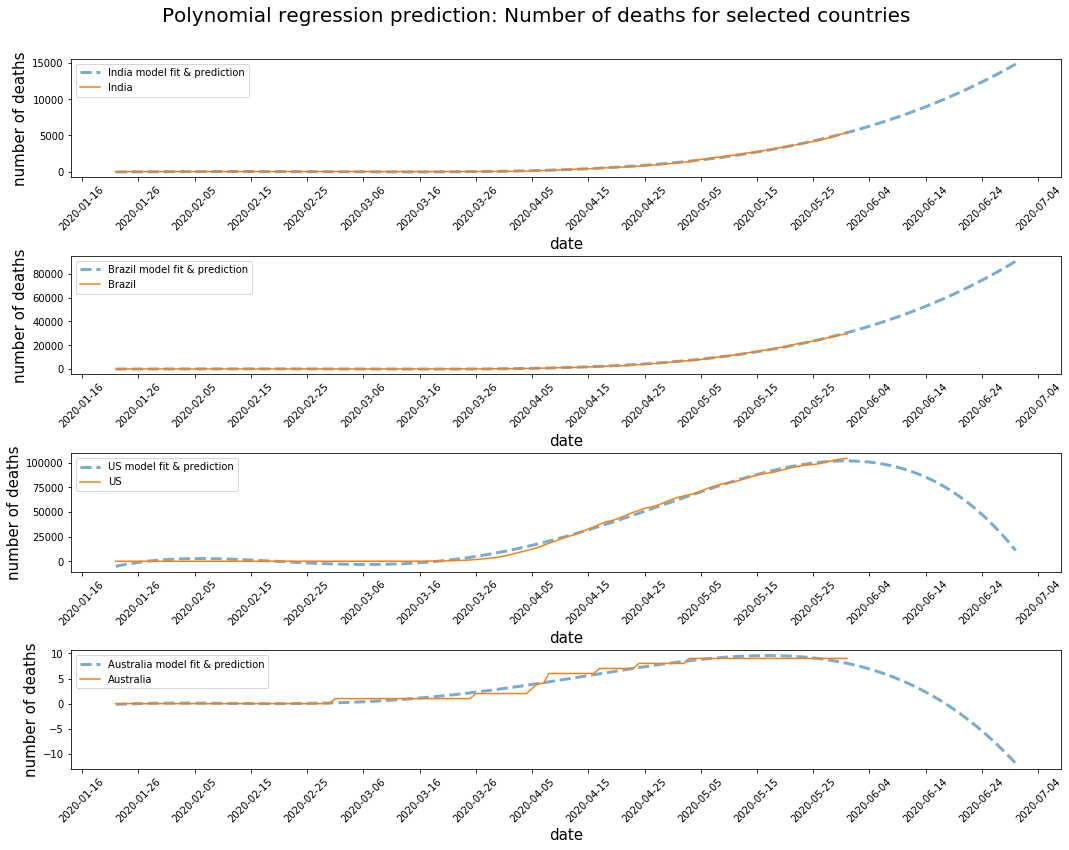

In [108]:
labels = ['number of deaths', 'Polynomial regression prediction: Number of deaths']
countryList = ['India', 'Brazil', 'US', 'Australia']
degreeList = [4, 4, 4, 4]
prediction_window = 30 #(30 days ~ 1 month)
polyPolyRegPrediction(deaths_df, labels, countryList, degreeList, prediction_window)

#### 3.1.3 Change in number of cases

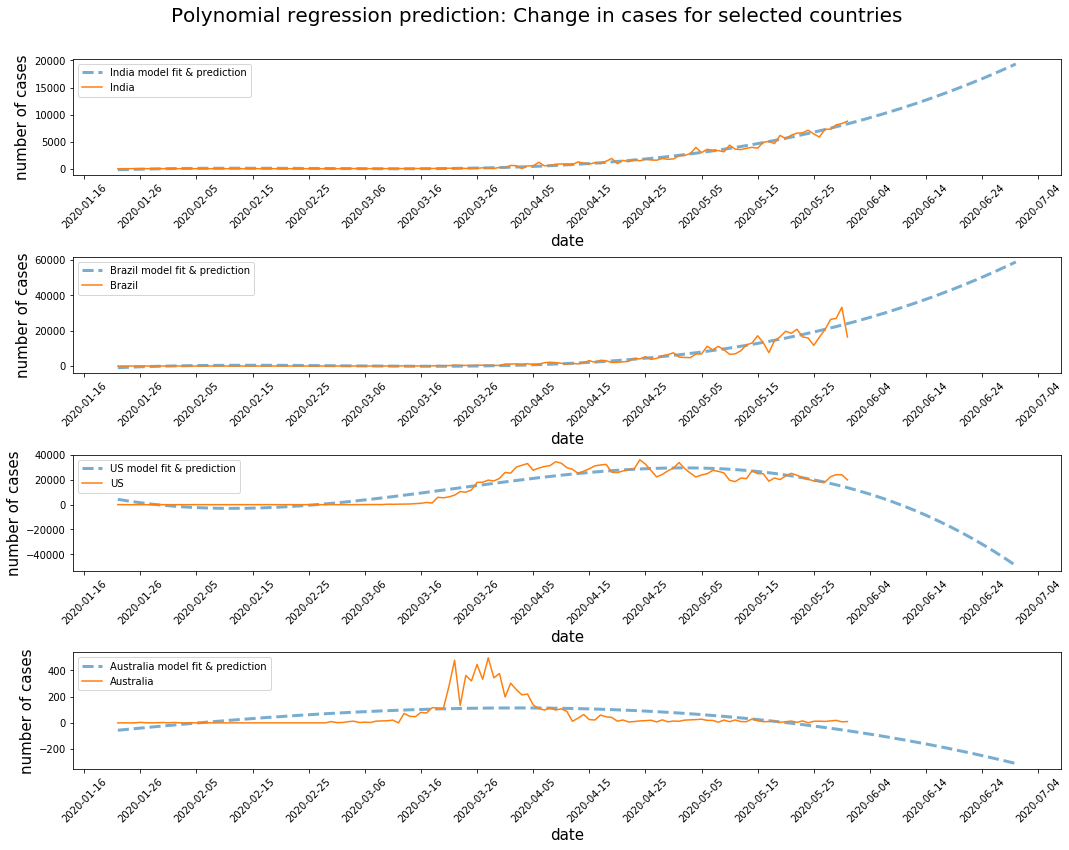

In [112]:
labels = ['number of cases', 'Polynomial regression prediction: Change in cases']
countryList = ['India', 'Brazil', 'US', 'Australia']
degreeList = [3, 3, 3, 3]
prediction_window = 30 #(30 days ~ 1 month)
polyPolyRegPrediction(changes_conf_df, labels, countryList, degreeList, prediction_window)

#### 3.1.4 Change in number of deaths

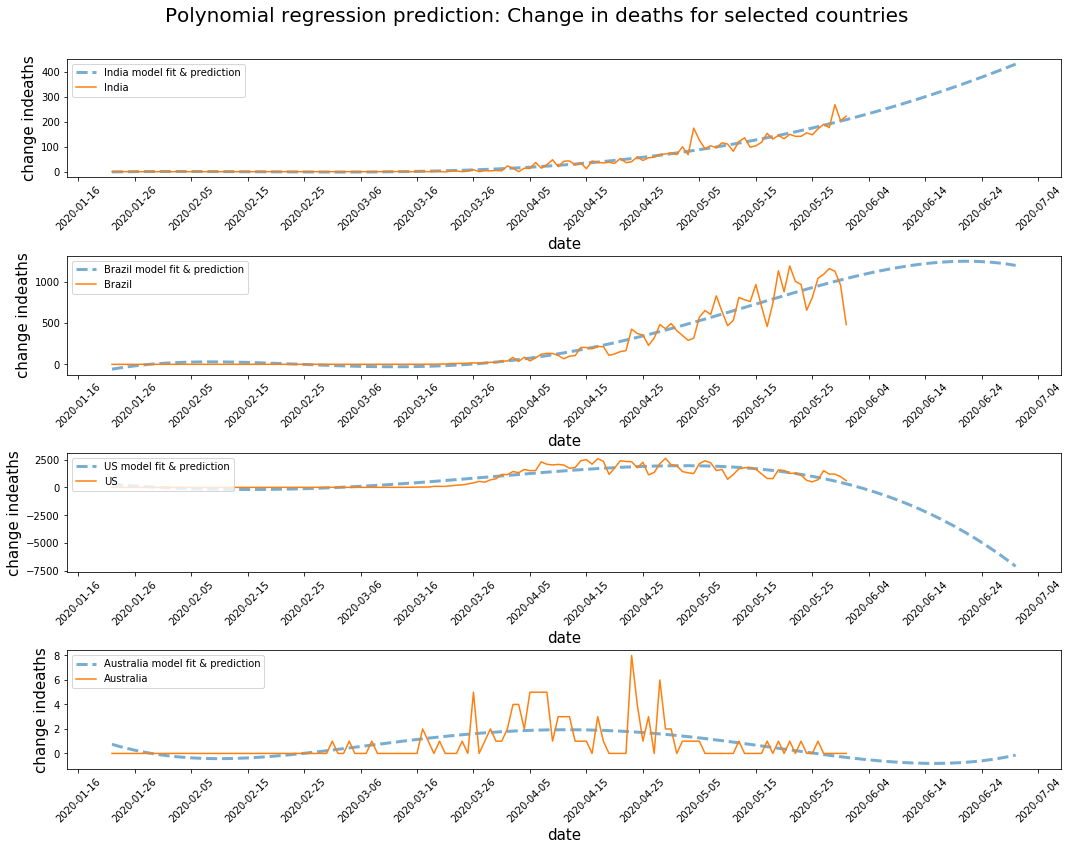

In [110]:
labels = ['change indeaths', 'Polynomial regression prediction: Change in deaths']
countryList = ['India', 'Brazil', 'US', 'Australia']
degreeList = [4, 4, 4, 4]
prediction_window = 30 #(30 days ~ 1 month)
polyPolyRegPrediction(changes_deaths_df, labels, countryList, degreeList, prediction_window)

- Predictions seem a little too optimistic for the US

#### 3.2 Gaussian process regression - with specified kernel 

- Really quite bad predicting the absolute number of cases/deaths!

#### 3.2.1 Number of cases

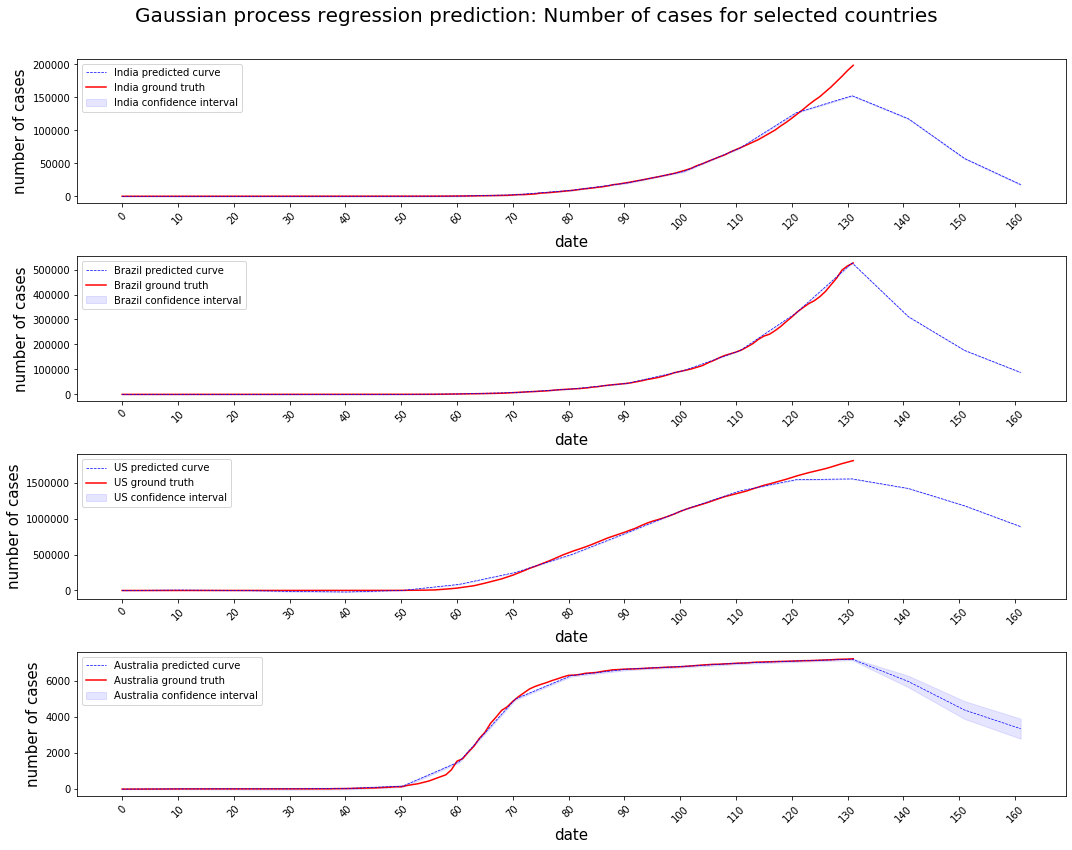

In [12]:
kernels = [
# 0: Simple Kernel
ConstantKernel(10.) * RationalQuadratic(length_scale=100., alpha=0.1),    
# 1: Simulate some noise with the high frequency oscillations of the ExpSineSquared kernel 
ConstantKernel(10.) * RationalQuadratic(alpha=0.1, length_scale=100) + ConstantKernel(10.)* ExpSineSquared(length_scale=0.01, periodicity=1001, length_scale_bounds=(0.00001, 1), periodicity_bounds=(1000, 100000)) 
]
alphaNoise = 0.5
countryList = ['India', 'Brazil', 'US', 'Australia']
labels = ['number of cases', 'Gaussian process regression prediction: Number of cases']
prediction_window = 30
kernel = kernels[1]
filtering = False
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotGaussPredictions(conf_df, labels, countryList, prediction_window, alphaNoise, kernel, filterInputs)

#### 3.2.2 Number of deaths

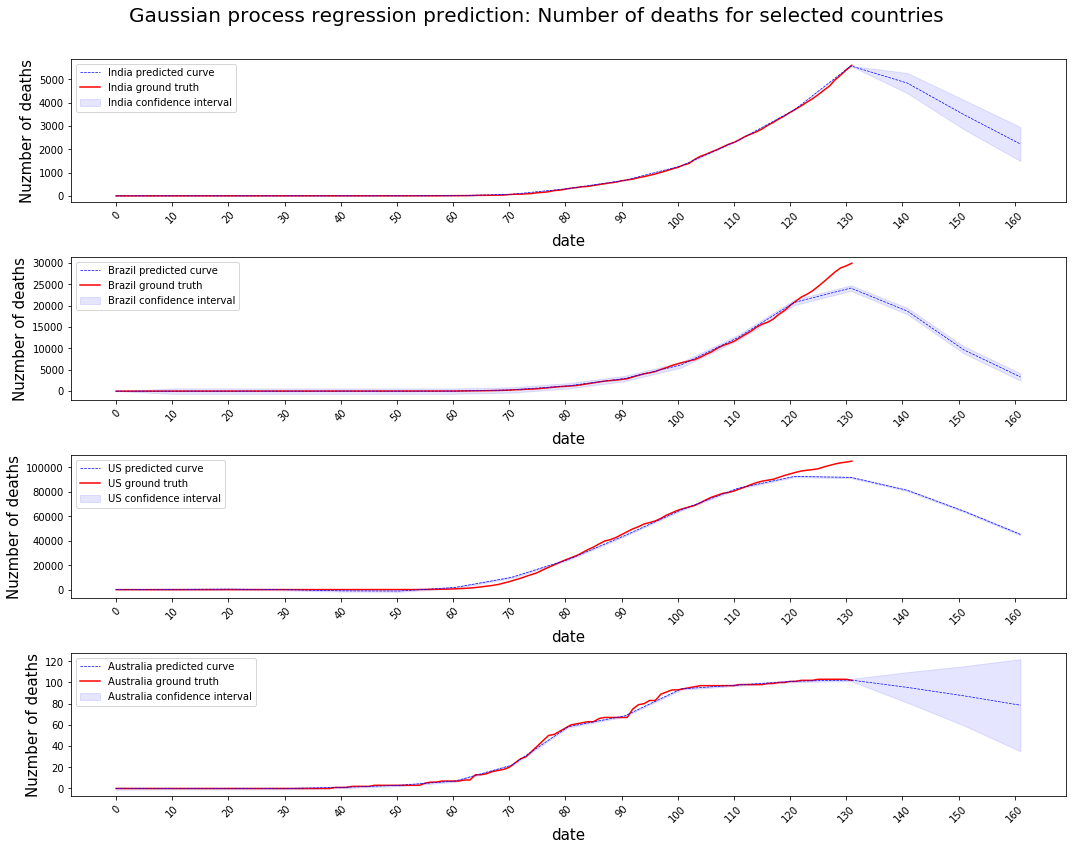

In [15]:
kernels = [
# 0: Simple Kernel
ConstantKernel(10.) * RationalQuadratic(length_scale=100., alpha=0.1),    
# 1: Simulate some noise with the high frequency oscillations of the ExpSineSquared kernel 
ConstantKernel(10.) * RationalQuadratic(alpha=0.1, length_scale=100) + ConstantKernel(10.)* ExpSineSquared(length_scale=0.01, periodicity=1001, length_scale_bounds=(0.00001, 1), periodicity_bounds=(1000, 100000)) 
]
alphaNoise = 0.5
labels = ['Nuzmber of deaths', 'Gaussian process regression prediction: Number of deaths']
#gpm = GaussianProcessRegressor(kernel=kk, n_restarts_optimizer=3, alpha=alphaNoise)
prediction_window = 30
kernel = kernels[1]
filtering = False
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotGaussPredictions(deaths_df, labels, countryList, prediction_window, alphaNoise, kernel, filterInputs)

#### 3.2.3 Change in number of cases

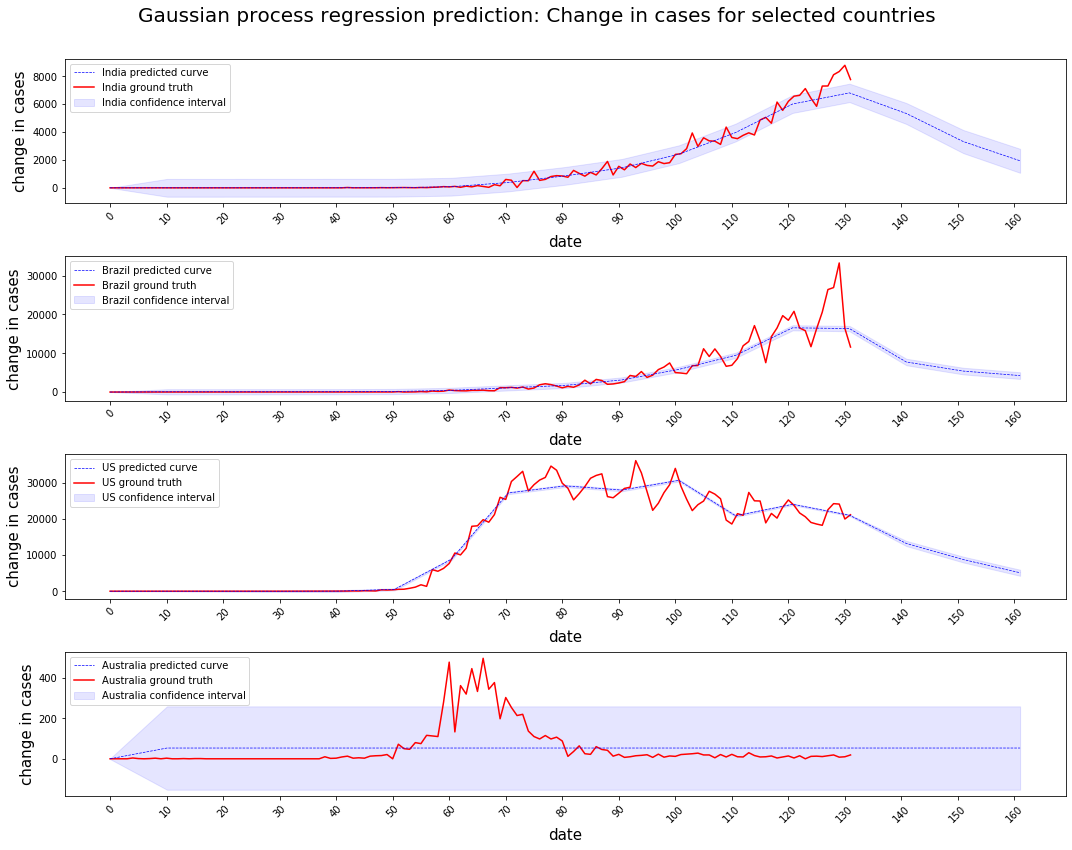

In [13]:
kernels = [
# 0: Simple Kernel
ConstantKernel(10.) * RationalQuadratic(length_scale=100., alpha=0.1),    
# 1: Simulate some noise with the high frequency oscillations of the ExpSineSquared kernel 
ConstantKernel(10.) * RationalQuadratic(alpha=0.1, length_scale=100) + ConstantKernel(10.)* ExpSineSquared(length_scale=0.01, periodicity=1001, length_scale_bounds=(0.00001, 1), periodicity_bounds=(1000, 100000)) 
]
alphaNoise = 0.5
labels = ['change in cases', 'Gaussian process regression prediction: Change in cases']
#gpm = GaussianProcessRegressor(kernel=kk, n_restarts_optimizer=3, alpha=alphaNoise)
prediction_window = 30
kernel = kernels[1]
filtering = False
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotGaussPredictions(changes_conf_df, labels, countryList, prediction_window, alphaNoise, kernel, filterInputs)

- Predictions appear overly optimistic!

#### 3.2.4 Change in number of deaths 

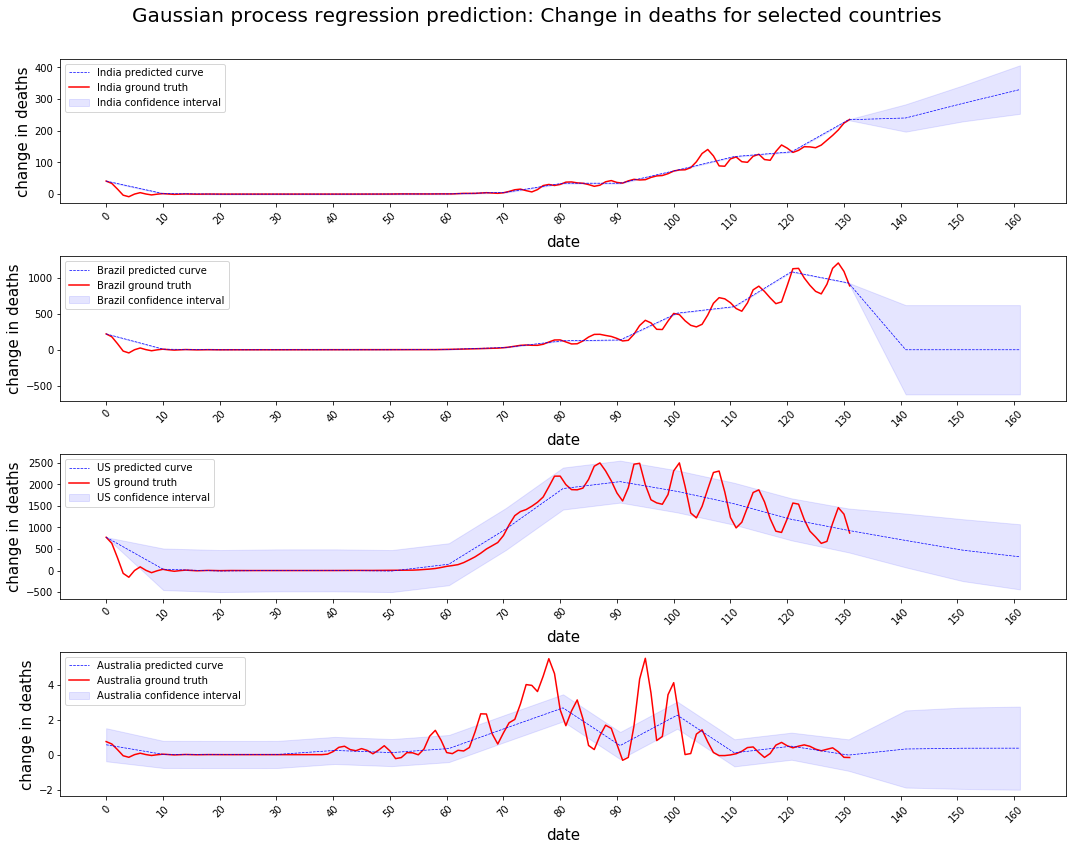

In [14]:
kernels = [
# 0: Simple Kernel
ConstantKernel(10.) * RationalQuadratic(length_scale=100., alpha=0.1),    
# 1: Simulate some noise with the high frequency oscillations of the ExpSineSquared kernel 
ConstantKernel(10.) * RationalQuadratic(alpha=0.1, length_scale=100) + ConstantKernel(10.)* ExpSineSquared(length_scale=0.01, periodicity=1001, length_scale_bounds=(0.00001, 1), periodicity_bounds=(1000, 100000)) 
]
alphaNoise = 0.5
labels = ['change in deaths', 'Gaussian process regression prediction: Change in deaths']
#gpm = GaussianProcessRegressor(kernel=kk, n_restarts_optimizer=3, alpha=alphaNoise)
prediction_window = 30
kernel = kernels[1]
filtering = True
Ts = 1 
order = 6  
cutoff = 0.25 
filterInputs = [filtering, Ts, order, cutoff]
plotGaussPredictions(changes_deaths_df, labels, countryList, prediction_window, alphaNoise, kernel, filterInputs)

#### 3.3 Multi-step time-series forecasting

#### 3.3.1 Setup single-step test model to find ideal number of lags to include

- Unpivot dataframe from wide to long format
- Trial selected few countries: 'Brazil', 'Mexico', 'US', 'Ecuador', 'India'
- Test basic Random Forest regression model with n-lags: Find optimal number of lags for regression

In [112]:
df_country = conf_df[(conf_df['Province/State'] == 'Brazil') | (conf_df['Province/State'] == 'Mexico') | 
                     (conf_df['Province/State'] == 'US') | (conf_df['Province/State'] == 'Ecuador') |
                     (conf_df['Province/State'] == 'India')]
df_country.drop(df_country.columns[1:4], axis = 1, inplace = True)
cols = ['Province/State']
cols = np.linspace(1, len(df_country.columns[1:]), len(df_country.columns[1:]), dtype = int)
cols = cols.astype('U')
cols = cols.tolist()
cols.insert(0,'Province/State')
df_country.columns = cols #np.linspace(1, len(df_country.columns[1:]), len(df_country.columns[1:]))
df_country.reset_index(drop = True, inplace = True)
df_country.head()

,Province/State,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132
0,Brazil,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,2,2,2,4,4,13,13,20,25,31,38,52,151,151,162,200,321,372,621,793,1021,1546,1924,2247,2554,2985,3417,3904,4256,4579,5717,6836,8044,9056,10360,11130,12161,14034,16170,18092,19638,20727,22192,23430,25262,28320,30425,33682,36658,38654,40743,43079,45757,50036,54043,59324,63100,67446,73235,79685,87187,92202,97100,101826,108620,115455,126611,135773,146894,156061,162699,169594,178214,190137,203165,220291,233511,241080,255368,271885,291579,310087,330890,347398,363211,374898,391222,411821,438238,465166,498440,514849,526447
1,Ecuador,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,7,10,13,13,13,14,15,15,17,17,17,28,28,37,58,111,199,367,506,789,981,1082,1173,1403,1595,1823,1924,1962,2240,2748,3163,3368,3465,3646,3747,3747,4450,4965,7161,7257,7466,7529,7603,7858,8225,8450,9022,9468,10128,10398,10850,11183,22719,22719,22719,23240,24258,24675,24934,26336,27464,29538,31881,31881,31881,30298,28818,29071,29559,29509,30419,30486,30502,31467,32763,33182,33582,34151,34854,35306,35828,36258,36756,37355,37355,38103,38471,38571,38571,39098,39098
2,India,0,0,0,0,0,0,0,0,1,1,1,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,5,5,28,30,31,34,39,43,56,62,73,82,102,113,119,142,156,194,244,330,396,499,536,657,727,887,987,1024,1251,1397,1998,2543,2567,3082,3588,4778,5311,5916,6725,7598,8446,9205,10453,11487,12322,13430,14352,15722,17615,18539,20080,21370,23077,24530,26283,27890,29451,31324,33062,34863,37257,39699,42505,46437,49400,52987,56351,59695,62808,67161,70768,74292,78055,81997,85784,90648,95698,100328,106475,112028,118226,124794,131423,138536,144950,150793,158086,165386,173491,181827,190609,198370
3,Mexico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,5,5,5,5,5,6,6,7,7,7,8,12,26,41,53,82,93,118,164,203,251,316,367,405,475,585,717,848,993,1094,1215,1378,1510,1688,1890,2143,2439,2785,3181,3441,3844,4219,4661,5014,5399,5847,6297,6875,7497,8261,8772,9501,10544,11633,12872,13842,14677,15529,16752,17799,19224,20739,22088,23471,24905,26025,27634,29616,31522,33460,35022,36327,38324,40186,42595,45032,47144,49219,51633,54346,56594,59567,62527,65856,68620,71105,74560,78023,81400,84627,87512,90664,93435
4,US,1,1,2,2,5,5,5,5,5,7,8,8,11,11,11,11,11,11,11,11,12,12,13,13,13,13,13,13,13,13,15,15,15,51,51,57,58,60,68,74,98,118,149,219,267,403,519,588,962,1285,1667,2181,2729,3536,4661,6437,7781,13748,19274,25600,33280,43862,53925,65844,83836,101962,121786,140910,162147,188172,213602,244008,275798,309027,336802,366317,397121,428654,463327,496846,526776,555313,580624,607670,636674,667981,700062,732590,758809,784708,811865,840351,869170,905358,938154,965785,988197,1012582,1039909,1069424,1103461,1132539,1158040,1180375,1204351,1229331,1257023,1283929,1309550,1329260,1347881,1369376,1390406,1417774,1442824,1467820,1486757,1508308,1528568,1551853,1577147,1600937,1622612,1643246,1662302,1680913,1699176,1721753,1746019,1770165,1790172,1811360


In [113]:
cat_vars = df_country.dtypes[df_country.dtypes == "object"].index
for i, var in enumerate(cat_vars):
    #print(var)
    df_country[var] = df_country[var].astype('category')
    df_country[var] = df_country[var].cat.codes

In [114]:
df_country = df_country.melt(id_vars='Province/State', var_name='Day', value_name='Cases')
df_country['Day'] = df_country['Day'].str.extract('(\d+)', expand=False).astype(int)
df_country = df_country.sort_values(['Day', 'Province/State'])
df_country.head()

,Province/State,Day,Cases
0,0,1,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,1


**Create baseline & Test**: (Need to be able to estimate better than this)
- Assume model predicts "tomorrow's cases" as "yesterday's cases"

In [76]:
mean_error = []
for day in range(110, len(conf_df.columns)-3):
    train = df_country_[df_country_['Day'] < day]
    val = df_country_[df_country_['Day'] == day]

    p = val['yesterday_cases'].values

    error = rmsle(val['Cases'].values, p)
    print('Day %d - Error %.5f' % (day, error), end = ',  ')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Day 110 - Error 0.04197,  Day 111 - Error 0.03462,  Day 112 - Error 0.04209,  Day 113 - Error 0.04272,  Day 114 - Error 0.04602,  Day 115 - Error 0.05091,  Day 116 - Error 0.04574,  Day 117 - Error 0.03504,  Day 118 - Error 0.04047,  Day 119 - Error 0.04593,  Day 120 - Error 0.04418,  Day 121 - Error 0.04413,  Day 122 - Error 0.04457,  Day 123 - Error 0.04016,  Day 124 - Error 0.03687,  Day 125 - Error 0.03070,  Day 126 - Error 0.03392,  Day 127 - Error 0.03856,  Day 128 - Error 0.03991,  Day 129 - Error 0.03888,  Day 130 - Error 0.04071,  Day 131 - Error 0.03110,  Day 132 - Error 0.02504,  Mean Error = 0.03975


**Trial models with varying numbers of lags and see how they all perform**

- **1 lag**: See how model performs

In [68]:
df_country_ = df_country.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()
df_country_.dropna(inplace = True)

#### Test Model

mean_error = []
start = len(conf_df.columns)-3 - 30
end = len(conf_df.columns)-3

for day in range(start, end):
    train = df_country_[df_country_['Day'] < day]
    val = df_country_[df_country_['Day'] == day]

    xtr, xts = train.drop(['Cases'], axis=1), val.drop(['Cases'], axis=1)
    ytr, yts = train['Cases'].values, val['Cases'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Day %d - Error %.5f' % (day, error), end = ',  ')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Day 103 - Error 0.03276,  Day 104 - Error 0.02976,  Day 105 - Error 0.05704,  Day 106 - Error 0.03280,  Day 107 - Error 0.06001,  Day 108 - Error 0.07683,  Day 109 - Error 0.04749,  Day 110 - Error 0.06244,  Day 111 - Error 0.04436,  Day 112 - Error 0.01949,  Day 113 - Error 0.02876,  Day 114 - Error 0.02627,  Day 115 - Error 0.06053,  Day 116 - Error 0.05031,  Day 117 - Error 0.03216,  Day 118 - Error 0.03850,  Day 119 - Error 0.03866,  Day 120 - Error 0.04228,  Day 121 - Error 0.02090,  Day 122 - Error 0.02250,  Day 123 - Error 0.04117,  Day 124 - Error 0.04375,  Day 125 - Error 0.04723,  Day 126 - Error 0.03003,  Day 127 - Error 0.02155,  Day 128 - Error 0.01534,  Day 129 - Error 0.02691,  Day 130 - Error 0.03195,  Day 131 - Error 0.02578,  Day 132 - Error 0.03967,  Mean Error = 0.03824


In [67]:

df_country_.head(5)

,Province/State,Day,Cases,yesterday_cases,yesterday_cases_diff
10,0,3,0,0.0,0.0
11,1,3,0,0.0,0.0
12,2,3,0,0.0,0.0
13,3,3,0,0.0,0.0
14,4,3,2,1.0,0.0


- **2 lags**: See if improvement ensures

In [71]:
df_country_ = df_country.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()
df_country_['Last-1_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(2)
df_country_['Last-1_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()
df_country_ = df_country_.dropna()

#### Test Model

mean_error = []
start = len(conf_df.columns)-3 - 30
end = len(conf_df.columns)-3

for day in range(start, end):
    train = df_country_[df_country_['Day'] < day]
    val = df_country_[df_country_['Day'] == day]

    xtr, xts = train.drop(['Cases'], axis=1), val.drop(['Cases'], axis=1)
    ytr, yts = train['Cases'].values, val['Cases'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Day %d - Error %.5f' % (day, error), end = ',  ')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Day 103 - Error 0.02978,  Day 104 - Error 0.03225,  Day 105 - Error 0.05490,  Day 106 - Error 0.03021,  Day 107 - Error 0.04374,  Day 108 - Error 0.04742,  Day 109 - Error 0.03424,  Day 110 - Error 0.05133,  Day 111 - Error 0.03952,  Day 112 - Error 0.02870,  Day 113 - Error 0.03017,  Day 114 - Error 0.02752,  Day 115 - Error 0.05294,  Day 116 - Error 0.05079,  Day 117 - Error 0.02972,  Day 118 - Error 0.03557,  Day 119 - Error 0.04026,  Day 120 - Error 0.04228,  Day 121 - Error 0.02575,  Day 122 - Error 0.02357,  Day 123 - Error 0.03330,  Day 124 - Error 0.04302,  Day 125 - Error 0.04507,  Day 126 - Error 0.03796,  Day 127 - Error 0.01929,  Day 128 - Error 0.01329,  Day 129 - Error 0.02138,  Day 130 - Error 0.03192,  Day 131 - Error 0.02295,  Day 132 - Error 0.04200,  Mean Error = 0.03536


- **3 lags**: See if improvement ensures

In [69]:

df_country_.head()

,Province/State,Day,Cases,yesterday_cases,yesterday_cases_diff,Last-1_yesterday_cases,Last-1_yesterday_case_Diff
15,0,4,0,0.0,0.0,0.0,0.0
16,1,4,0,0.0,0.0,0.0,0.0
17,2,4,0,0.0,0.0,0.0,0.0
18,3,4,0,0.0,0.0,0.0,0.0
19,4,4,2,2.0,1.0,1.0,0.0


In [74]:
df_country_ = df_country.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()

df_country_['Last-1_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(2)
df_country_['Last-1_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()

df_country_['Last-2_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(3)
df_country_['Last-2_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-2_yesterday_cases'].diff()
df_country_ = df_country_.dropna()
 
    
#### Test Model

mean_error = []
start = len(conf_df.columns)-3 - 30
end = len(conf_df.columns)-3

for day in range(start, end):
    train = df_country_[df_country_['Day'] < day]
    val = df_country_[df_country_['Day'] == day]

    xtr, xts = train.drop(['Cases'], axis=1), val.drop(['Cases'], axis=1)
    ytr, yts = train['Cases'].values, val['Cases'].values

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Day %d - Error %.5f' % (day, error), end = ',  ')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

Day 103 - Error 0.03099,  Day 104 - Error 0.03117,  Day 105 - Error 0.04560,  Day 106 - Error 0.03449,  Day 107 - Error 0.05270,  Day 108 - Error 0.04286,  Day 109 - Error 0.03143,  Day 110 - Error 0.04725,  Day 111 - Error 0.03946,  Day 112 - Error 0.02716,  Day 113 - Error 0.02589,  Day 114 - Error 0.02815,  Day 115 - Error 0.04626,  Day 116 - Error 0.04638,  Day 117 - Error 0.03609,  Day 118 - Error 0.03712,  Day 119 - Error 0.04213,  Day 120 - Error 0.03960,  Day 121 - Error 0.02996,  Day 122 - Error 0.02635,  Day 123 - Error 0.03640,  Day 124 - Error 0.04193,  Day 125 - Error 0.05111,  Day 126 - Error 0.04127,  Day 127 - Error 0.02436,  Day 128 - Error 0.02022,  Day 129 - Error 0.02046,  Day 130 - Error 0.03093,  Day 131 - Error 0.02413,  Day 132 - Error 0.04027,  Mean Error = 0.03574


- Error increased: Therefore 2 lags appeared to perform best!

- **4 lags**: Double check this also worsens

In [90]:
df_country_ = df_country.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()

df_country_['Last-1_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(2)
df_country_['Last-1_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()

df_country_['Last-2_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(3)
df_country_['Last-2_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-2_yesterday_cases'].diff()

df_country_['Last-3_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(4)
df_country_['Last-3_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-3_yesterday_cases'].diff()

df_country_ = df_country_.dropna()

#### Test Model

mean_error = []
start = len(conf_df.columns)-3 - 30
end = len(conf_df.columns)-3

for day in range(start, end):
    train = df_country_[df_country_['Day'] < day]
    val = df_country_[df_country_['Day'] == day]

    xtr, xts = train.drop(['Cases'], axis=1), val.drop(['Cases'], axis=1)
    ytr, yts = train['Cases'].values, val['Cases'].values
    print (xts)
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)

    error = rmsle(yts, p)
    print('Day %d - Error %.5f' % (day, error), end = ',  ')
    mean_error.append(error)
print('Mean Error = %.5f' % np.mean(mean_error))

     Province/State  Day  yesterday_cases  yesterday_cases_diff  \
510               0  103          97100.0                4898.0   
511               1  103          27464.0                1128.0   
512               2  103          39699.0                2442.0   
513               3  103          22088.0                1349.0   
514               4  103        1132539.0               29078.0   

     Last-1_yesterday_cases  Last-1_yesterday_case_Diff  \
510                 92202.0                      5015.0   
511                 26336.0                      1402.0   
512                 37257.0                      2394.0   
513                 20739.0                      1515.0   
514               1103461.0                     34037.0   

     Last-2_yesterday_cases  Last-2_yesterday_case_Diff  \
510                 87187.0                      7502.0   
511                 24934.0                       259.0   
512                 34863.0                      1801.0   
513   

KeyboardInterrupt: 

- Error increased further for 4 lags

#### 3.3.2 Construct multi-step time-series forecasting model

In [86]:
df_country.head()

,Province/State,Day,Cases
0,0,1,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,1


In [183]:
df_country_backup = df_country.copy()
df_country_ = df_country_backup.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()
df_country_['Last-1_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(2)
df_country_['Last-1_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()
df_country_ = df_country_.dropna()

#### Predict with multi-step model

mean_error = []
start = len(conf_df.columns)-4
end = len(conf_df.columns)-4 + 50

for day in range(start, end):
    print(day)
    train = df_country_[df_country_['Day'] == day]
    #val = df_country_[df_country_['Day'] == day]

    xtr = train.drop(['Cases'], axis=1)#, val.drop(['Cases'], axis=1)
    ytr = train['Cases'].values#, val['Cases'].values
    #print(xts)

    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)

    p = mdl.predict(xts)
    
    list_ = []
    for i in range(5):
        print([i, day, p[i]])
        list_.append([i, day, p[i]])
    list_ = pd.DataFrame(list_, columns = df_country_backup.columns)
    df_country_backup = pd.concat([df_country_backup, list_])
    df_country_backup.reset_index(drop = True, inplace = True)
    df_country_ = df_country_backup.copy()
    df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
    df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()
    df_country_['Last-1_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(2)
    df_country_['Last-1_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()
    df_country_ = df_country_.dropna()
        


132


ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required.

In [188]:
list_ = [[0, 1, 2, 3, 4], [day]*5, df_country_.Cases.tail(5).values.tolist(), df_country_.Cases.tail(10).values[0:5].tolist(), (df_country_.Cases.tail(5) - df_country_.Cases.tail(10).values[0:5]).tolist(), df_country_.Cases.tail(15).values[0:5].tolist(), df_country_.yesterday_cases_diff.tail(5).values.tolist()]

In [189]:
list_

[[0, 1, 2, 3, 4],
 [132, 132, 132, 132, 132],
 [526447, 39098, 198370, 93435, 1811360],
 [514849, 39098, 190609, 90664, 1790172],
 [11598, 0, 7761, 2771, 21188],
 [498440, 38571, 181827, 87512, 1770165],
 [16409.0, 527.0, 8782.0, 3152.0, 20007.0]]

In [190]:
cols

Index(['Province/State', 'Day', 'yesterday_cases', 'yesterday_cases_diff',
       'Last-1_yesterday_cases', 'Last-1_yesterday_case_Diff'],
      dtype='object')

In [178]:
df_country_.drop('Cases', axis = 1, inplace = True)
cols = df_country_.columns
#df_country_.columns.pop('Cases')

KeyError: "['Cases'] not found in axis"

In [192]:
df.head()

,Province/State,Day,yesterday_cases,yesterday_cases_diff,Last-1_yesterday_cases,Last-1_yesterday_case_Diff
0,0,132,526447,514849,11598,498440
1,1,132,39098,39098,0,38571
2,2,132,198370,190609,7761,181827
3,3,132,93435,90664,2771,87512
4,4,132,1811360,1790172,21188,1770165


In [191]:
df = pd.DataFrame()
for i, col in enumerate(cols):
    df[col] = list_[i]


In [179]:
df = pd.DataFrame(df, columns = cols)

ValueError: 6 columns passed, passed data had 5 columns

In [172]:
df_country_backup = df_country.copy()
df_country_ = df_country_backup.copy()
df_country_['yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift()
df_country_['yesterday_cases_diff'] = df_country_.groupby(['Province/State'])['yesterday_cases'].diff()
df_country_['Last-1_yesterday_cases'] = df_country_.groupby(['Province/State'])['Cases'].shift(2)
df_country_['Last-1_yesterday_case_Diff'] = df_country_.groupby(['Province/State'])['Last-1_yesterday_cases'].diff()
df_country_ = df_country_.dropna()
#df = pd.DataFrame(df, columns = df_country_.drop('Cases', axis = 1, inplace = True).columns)

In [173]:
df_country_.head()

,Province/State,Day,Cases,yesterday_cases,yesterday_cases_diff,Last-1_yesterday_cases,Last-1_yesterday_case_Diff
15,0,4,0,0.0,0.0,0.0,0.0
16,1,4,0,0.0,0.0,0.0,0.0
17,2,4,0,0.0,0.0,0.0,0.0
18,3,4,0,0.0,0.0,0.0,0.0
19,4,4,2,2.0,1.0,1.0,0.0


In [171]:
#df_country_ = df_country_backup.copy()
df_country_.drop('Cases', axis = 1, inplace = True)
df_country_.columns

Index(['Province/State', 'Day', 'yesterday_cases', 'yesterday_cases_diff',
       'Last-1_yesterday_cases', 'Last-1_yesterday_case_Diff'],
      dtype='object')

In [152]:
(df_country_.Cases.tail(5) - df_country_.Cases.tail(10).values[0:5]).tolist()

[38819.427999999956,
 348.9499999999971,
 10919.236000000004,
 167.69500000000698,
 -50662.70299999998]

In [155]:
df_country_.Cases.tail(10).values[0:5]

array([ 526447.,   39098.,  198370.,   93435., 1811360.])

In [149]:
df_country_.Cases.tail(5).tolist()

[565266.428, 39446.95, 209289.236, 93602.695, 1760697.297]

In [142]:
df_country_.tail(10)

,Province/State,Day,Cases,yesterday_cases,yesterday_cases_diff,Last-1_yesterday_cases,Last-1_yesterday_case_Diff
655,0,132,526447.000,514849.0,16409.0,498440.0,33274.0
656,1,132,39098.000,39098.0,527.0,38571.0,0.0
657,2,132,198370.000,190609.0,8782.0,181827.0,8336.0
658,3,132,93435.000,90664.0,3152.0,87512.0,2885.0
659,4,132,1811360.000,1790172.0,20007.0,1770165.0,24146.0
660,0,132,565266.428,526447.0,11598.0,514849.0,16409.0
661,1,132,39446.950,39098.0,0.0,39098.0,527.0
662,2,132,209289.236,198370.0,7761.0,190609.0,8782.0
663,3,132,93602.695,93435.0,2771.0,90664.0,3152.0
664,4,132,1760697.297,1811360.0,21188.0,1790172.0,20007.0


In [132]:
list_ = []
for i in range(5):
    print([i, day, p[i]])
    list_.append([i, day, p[i]])
list_ = pd.DataFrame(list_, columns = df_country_backup.columns)
df_country_backup = pd.concat([df_country_backup, list_])
#df_country_backup.append(list_, ignore_index = True)
df_country_backup.tail()

[0, 133, 565266.428]
[1, 133, 39446.95]
[2, 133, 209289.236]
[3, 133, 93602.695]
[4, 133, 1760697.297]


,Province/State,Day,Cases
0,0,133,565266.428
1,1,133,39446.950
2,2,133,209289.236
3,3,133,93602.695
4,4,133,1760697.297


In [101]:
df_temp = df_country.copy()

for i in range(5):
    df_temp.append([i, day, p[i]])
df_temp.tail()

,Province/State,Day,Cases
655,0,132,526447
656,1,132,39098
657,2,132,198370
658,3,132,93435
659,4,132,1811360


In [95]:
df_temp = df_country_.copy()
df_temp.drop(['Cases'], axis = 1, inplace = True)
df_temp.tail()

,Province/State,Day,yesterday_cases,yesterday_cases_diff,Last-1_yesterday_cases,Last-1_yesterday_case_Diff
655,0,132,514849.0,16409.0,498440.0,33274.0
656,1,132,39098.0,527.0,38571.0,0.0
657,2,132,190609.0,8782.0,181827.0,8336.0
658,3,132,90664.0,3152.0,87512.0,2885.0
659,4,132,1790172.0,20007.0,1770165.0,24146.0


In [97]:
df_country_.tail().Cases.values.tolist()

[526447, 39098, 198370, 93435, 1811360]

In [ ]:
df_temp = df_country_.copy()
col0 = [0, 1, 2, 3, 4]
col1 = [day]*5
col2 = p
col3 = df_country_

In [ ]:
lst_feat = [brwCycle]
        try:
            for i in range(0, len(brew_list)):
                if i < 5:
                    lst_feat.append(brew_list[i].RelChangeBrwDur.values[brwCycle])
                else:
                    for i in range(0, num_lags):
                        lag_str = 'RelBrwDur_lag' + str(i+1)
                        lst_feat.append(train[lag_str].values[brwCycle-3])
                    break

            feat_arr = np.atleast_2d(lst_feat)
            p = mdl.predict(feat_arr)
            #lst_feat.append(p[0] + np.random.normal(0,1,1)[0])
            lst_feat.append(p[0]) # + np.random.normal(0,1,1)[0])
            df_gain.loc[len(df_gain)+2] = lst_feat

        except IndexError:
            print("end of dataframe")
            break

In [197]:
df_country = conf_df[conf_df['Province/State'] == 'Australia']
y_val =  df_country[df_country.columns[4:]].values[0]
df_ = pd.DataFrame()
df_['X-Value'] = np.linspace(0, len(y_val)-1, len(y_val))
df_['Y-Value'] = y_val
df_['Y-Value_lag1'] = df_['Y-Value'].shift(1)
df_['Y-Value_lag2'] = df_['Y-Value'].shift(2)
df_.tail()

,X-Value,Y-Value,Y-Value_lag1,Y-Value_lag2
126,126.0,7150,7139.0,7126.0
127,127.0,7165,7150.0,7139.0
128,128.0,7184,7165.0,7150.0
129,129.0,7192,7184.0,7165.0
130,130.0,7202,7192.0,7184.0


In [ ]:
for i in range(5, 8):
    num_lags = 2
    df_i = i
    df = returnStartingDf(num_lags, df, brew_list)

    #model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
    model = LGBMRegressor(n_estimators=150, learning_rate=0.5, max_depth = 5, gamma = 0.07)

    equal_length_datasets = 1
    if equal_length_datasets:
        brew_list = brew_list_equal.copy() 

    output_interval = 20                                                      # how often to print progress                                                           # amount of lags given to model
    prediction_length = 300                                                   # how far to predict into future
    printFeatImportance = 1                                                   # print feature importances
    plotResult = 1
    df_predicted = run_prediction(output_interval, model, num_lags, df, prediction_length, printFeatImportance, plotResult)

In [ ]:
df_PCA_num = convertToPCA(train_num, 37)
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

max_params = optimiseRF(df_PCA_num, bounds_)                                      
rfModel = RandomForestRegressor(**max_params['params'])
testModel(df = df_PCA_num, n_splits = 10, model = rfModel)

In [ ]:
rf = 0
# A parameter grid for Random Forest:
if rf == 1:
    bounds = {#df_, 
            #modelType = 1
            #'min_child_weight': (1, 10),
            #'gamma': (0,1),
            #'subsample': (0.3, 1.0),
            #'colsample_bytree': (0.3, 1.0),
            'max_depth': (3, 5),
            #'learning_rate': (0.1, 0.8),
            'n_estimators':(50,150),
            }
    
# A parameter grid for LightGBM:
else:
    bounds = {#df_, 
            #modelType = 2
            #'min_child_weight': (1, 10),
            'gamma': (0,1),
            #'subsample': (0.3, 1.0),
            #'colsample_bytree': (0.3, 1.0),
            'max_depth': (3, 5),
            'learning_rate': (0.1, 0.8),
            'n_estimators':(50,150),
            }

# Define Bayesian Optimizer:
optimizer = BayesianOptimization(f=train_bayes_opt2,  pbounds=bounds, random_state=1)

optimizer.maximize(init_points=10, n_iter=50)

In [ ]:
def train_bayes_opt2(#min_child_weight, 
                #df_, 
                #modelType,
                max_depth,
                gamma, 
                learning_rate, 
                #subsample, 
                #colsample_bytree,
                n_estimators):
    
    modelType = 2
    if modelType == 1:
        params = {
            #'min_child_weight': int(min_child_weight),
            'max_depth': int(max_depth),
            'n_jobs': -1,
            #'subsample':subsample,
            #'colsample_bytree':colsample_bytree,
            'n_estimators':int(n_estimators)
        }
    
    elif modelType == 2:
        
            params = {
            #'min_child_weight': int(min_child_weight),
            'max_depth': int(max_depth),
            'gamma': gamma,
            'learning_rate':learning_rate,
            #'subsample':subsample,
            #'colsample_bytree':colsample_bytree,
            'n_estimators':int(n_estimators)
        }
            
            
    ''' Optimise on all tests until min brew cycles completed in test3 (i.e 377 cycles is max number of rows for training) '''  
    
    
  
    ''' Optimise on only tests 1 & 2 but entire datasets '''  
   
  
    SUM_avgRMSE_ALL = []
    for i, col in enumerate(df_.columns):
        if i > 0: # not Brwcycles
            dfY = df_[col]
            dfY = pd.DataFrame(dfY, dtype='float')
            y = dfY.values
            colList = df_.columns.tolist()
            colList.remove(col)
            X = df_[colList].values

            # Start optimisation
            n_splits = 3
            kf = KFold(n_splits, True, 1)
            rmseScores = []

            for train_index, test_index in kf.split(X):
                trainX, testX = X[train_index], X[test_index]
                trainy, testy = y[train_index], y[test_index]

                if modelType == 1:
                    mdl = RandomForestRegressor(**params)
                elif modelType == 2:
                    mdl = LGBMRegressor(**params, silent = True)

                mdl.fit(trainX,trainy)
                preds = mdl.predict(testX)
                #rmse = sqrt(mean_squared_error(np.exp(testy),  np.exp(preds)))
                error = rmsle(testy, preds)
                rmseScores.append(error)
                #print("rmse = ", rmse)

            avgRMSE = sum(rmseScores) / n_splits
            SUM_avgRMSE_ALL.append(avgRMSE)

    avgRMSE = sum(SUM_avgRMSE_ALL) / len(SUM_avgRMSE_ALL)

    return -avgRMSE

In [ ]:
#### ---------------------------------- HELPER FUNCTIONS --------------------------------------------------------------------

def testModel(df, n_splits, model, returnVal = False, printOutput = True):
    
    X = df.drop(['SalePrice'], axis = 1).values
    y = df.drop(df.columns.difference(['SalePrice']), axis = 1).values
    kf = KFold(n_splits, True, 1)
    rmsleScores = []
    
    if printOutput:
        print("RMSLE Value For Kf_i: ", end = ' ')
    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        model_ = clone(model)
        model_.fit(trainX,trainy)
        preds = model_.predict(testX)
        rmsleScore = rmsle(np.exp(testy), np.exp(preds))
        rmsleScores.append(rmsleScore)
        if printOutput:
            print(round(rmsleScore, 2), end = ', ')
    if printOutput:
        print ("Average RMSLE: ", round(sum(rmsleScores) / n_splits, 3))
    if returnVal:
        return round(sum(rmsleScores) / n_splits, 3)

## -----------------------------------------------------------------------------------------------------------------------

def run_train_test_split(df, estimator):
    X = df.drop(['SalePrice'], axis = 1).values
    y = df.drop(df.columns.difference(['SalePrice']), axis = 1).values
    rmsle_scorer = make_scorer(rmsle, greater_is_better=False)
    cval = cross_val_score(estimator, X, y, scoring=rmsle_scorer, cv=4, n_jobs = -1)
    return cval.mean()

#### ---------------------------------- LOSS FUNCTION --------------------------------------------------------------------
def rmsle(ytrue, ypred):
    try:
        return np.sqrt(mean_squared_log_error(ytrue, ypred))
    except ValueError:
        return np.sqrt(mean_squared_log_error(ytrue + 100, ypred + 100)) # prevent negative log-values   
    

#### ---------------------------------- OPTIMISERS --------------------------------------------------------------------

# -------   RandomForest optimiser   -------
def optimiseRF(data, pbounds_):
    
    def train_bayes_opt_rforest(max_depth, min_impurity_decrease, n_estimators):
        params_ = {
            'max_depth': int(round(max_depth)),
            'min_impurity_decrease': float(min_impurity_decrease),
            'n_estimators': int(round(n_estimators))
        }
        mdl = RandomForestRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_rforest, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   XGBoost optimiser   -------
def optimiseXGBoost(data, pbounds_):
    
    def train_bayes_opt_XGBoost(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = xgb.XGBRegressor(**params_, silent = True)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_XGBoost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators']))
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   LightGBM optimiser   -------
def optimiseLightGBM(data, pbounds_):
    
    def train_bayes_opt_LightGBM(max_depth, gamma, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = LGBMRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_LightGBM, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   GradientBoost optimiser   -------
def optimiseGradBoost(data, pbounds_):
    
    def train_bayes_opt_gradboost(max_depth, min_impurity_decrease, learning_rate, n_estimators):
        params_ = {       
        'max_depth': int(round(max_depth)),
        'min_impurity_decrease': min_impurity_decrease,
        'learning_rate':learning_rate,
        'n_estimators':int(round(n_estimators))
        }
        mdl = GradientBoostingRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_gradboost, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['max_depth'] = int(round(max_params['params']['max_depth']))
    max_params['params']['n_estimators'] = int(round(max_params['params']['n_estimators'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------

# -------   kNN optimiser   -------
def optimiseKNN(data, pbounds_):
    
    def train_bayes_opt_kNN(n_neighbors, leaf_size, p):
        params_ = {       
        'n_neighbors': int(round(n_neighbors)),
        'leaf_size':int(round(leaf_size)),
        'p': int(round(p))
        }
        mdl = KNeighborsRegressor(**params_)
        return run_train_test_split(data, mdl)
    
    optimizer = BayesianOptimization(f=train_bayes_opt_kNN, pbounds = pbounds_, random_state=1)
    optimizer.maximize(init_points=10, n_iter=30)

    print("Final result:", optimizer.max)
    max_params = optimizer.max
    max_params['params']['n_neighbors'] = int(round(max_params['params']['n_neighbors']))
    max_params['params']['leaf_size'] = int(round(max_params['params']['leaf_size'])) 
    max_params['params']['p'] = int(round(max_params['params']['p'])) 
    return max_params

## -----------------------------------------------------------------------------------------------------------------------
